# A2
## Ordinary Least Squares (OLS) Regression
- Basic linear regression model that fits a line to minimize the sum of squared differences between actual and predicted values.
- Strength: Easy to interpret.
- Weakness: Sensitive to noise, overfits when there are too many variables.

## Lasso Regression (L1 Regularization)
- A regularized version of OLS that penalizes large coefficients to enforce sparsity.
- Strength: Feature selection, avoids overfitting.
- Weakness: Can overly shrink coefficients.

## Ridge Regression (L2 Regularization)
- Similar to Lasso but penalizes squared values of coefficients instead of absolute values.
- Strength: Helps with multicollinearity (correlated predictors).
- Weakness: Does not perform feature selection.

## ElasticNet Regression
- A combination of Lasso and Ridge.
- Strength: Balances feature selection (Lasso) and shrinkage (Ridge).
- Weakness: Requires tuning two hyperparameters 

##  k-Nearest Neighbors (kNN)
- Non-parametric model that predicts returns based on similar past instances.
- It looks at the k most similar past observations (neighbors) and takes an average
- Strength: Captures non-linear patterns.
- Weakness: Computationally expensive, requires tuning 


In [47]:
import pandas as pd
import os

# Set path to your CSV folder
csv_folder = "A2csv files"  # Adjust this if needed

# Load SPY Data
spy_df = pd.read_csv(os.path.join(csv_folder, "SPY.csv"))
spy_df["Dt"] = pd.to_datetime(spy_df["Dt"])  # Convert to datetime format
spy_df.set_index("Dt", inplace=True)

# Function to compute lagged returns
def compute_lagged_returns(df, column="Close", lags=[5, 10, 20, 40]):  # 1W (5), 2W (10), 1M (20), 2M (40)
    """Computes lagged percentage returns for given lags."""
    for lag in lags:
        df[f"{column}_lag_{lag}"] = df[column].pct_change(lag)
    return df

# Compute lagged returns for SPY
spy_df = compute_lagged_returns(spy_df)

# List of fixed indices to use
selected_indices = ["XLK", "XLRE", "XLV"]

# Load index data and compute lagged returns for selected indices
index_dfs = {}
for ticker in selected_indices:
    file_path = os.path.join(csv_folder, f"{ticker}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Dt"] = pd.to_datetime(df["Dt"])
        df.set_index("Dt", inplace=True)
        df = compute_lagged_returns(df)
        index_dfs[ticker] = df

# Merge SPY with selected index data
merged_df = spy_df.copy()
for ticker, df in index_dfs.items():
    for lag in [5, 10, 20, 40]:
        merged_df[f"{ticker}_lag_{lag}"] = df[f"Close_lag_{lag}"]

# Drop NaN values from initial lagged calculations
merged_df.dropna(inplace=True)

# Target variable: Next-day SPY return
merged_df["next_day_return"] = spy_df["Close"].pct_change().shift(-1)

# Drop rows with missing target values
merged_df.dropna(inplace=True)

# Save final dataset for modeling
merged_df.to_csv("momentum_strategy_dataset.csv")

# Output results
print("Data preprocessing complete. File saved as 'momentum_strategy_dataset.csv'.")
print("Selected Indices:", selected_indices)
print(merged_df)


Data preprocessing complete. File saved as 'momentum_strategy_dataset.csv'.
Selected Indices: ['XLK', 'XLRE', 'XLV']
             Close  Close_lag_5  Close_lag_10  Close_lag_20  Close_lag_40  \
Dt                                                                          
2018-02-26  277.90     0.017539      0.062715     -0.030288      0.039578   
2018-02-27  274.43     0.011164      0.034258     -0.036005      0.024489   
2018-02-28  271.65     0.005925      0.021241     -0.035882      0.017949   
2018-03-01  267.70    -0.009985     -0.007011     -0.050372     -0.003981   
2018-03-02  269.08    -0.020494     -0.014467     -0.044392     -0.005139   
...            ...          ...           ...           ...           ...   
2018-12-21  240.70    -0.075901     -0.086770     -0.091767     -0.092794   
2018-12-24  234.34    -0.082315     -0.112584     -0.109820     -0.132331   
2018-12-26  246.18    -0.034891     -0.067959     -0.079701     -0.072174   
2018-12-27  248.07    -0.012696     

## Ordinary Least Squares (OLS) Regression

OLS Regression Results:
Mean Squared Error (MSE): 0.000337
R-squared (R2): -0.422365


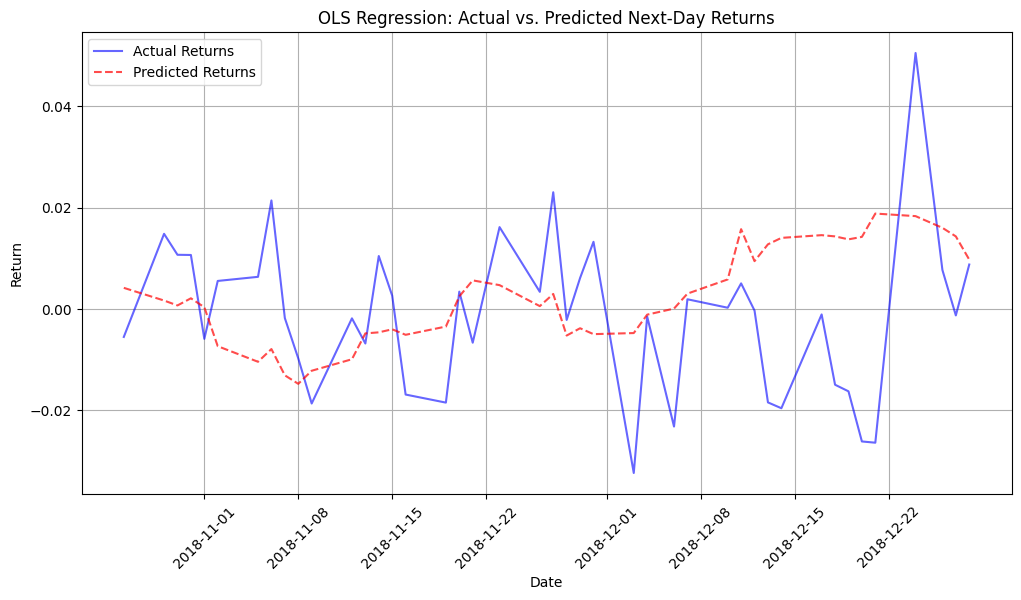

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load processed dataset
file_path = "momentum_strategy_dataset.csv"  # Adjust if needed
df = pd.read_csv(file_path, index_col="Dt", parse_dates=True)

# Define predictors and target variable
predictors = [col for col in df.columns if "lag" in col]
target = "next_day_return"

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target], test_size=0.2, shuffle=False)

# Train OLS model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predict next-day returns
y_pred = ols_model.predict(X_test)

# Evaluate model performance
ols_mse = mean_squared_error(y_test, y_pred)
ols_r2 = r2_score(y_test, y_pred)

# Print model evaluation results
print("OLS Regression Results:")
print(f"Mean Squared Error (MSE): {ols_mse:.6f}")
print(f"R-squared (R2): {ols_r2:.6f}")

# Plot actual vs predicted returns
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Returns", color="blue", alpha=0.6)
plt.plot(y_test.index, y_pred, label="Predicted Returns", color="red", linestyle="dashed", alpha=0.7)

# Formatting the plot
plt.title("OLS Regression: Actual vs. Predicted Next-Day Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()


## Lasso Regression (L1 Regularization)


Lasso Regression Results:
Mean Squared Error (MSE): 0.000297
R-squared (R2): -0.253764
Selected Features by Lasso: ['Close_lag_5', 'Close_lag_40', 'XLK_lag_5', 'XLK_lag_10', 'XLK_lag_20', 'XLRE_lag_5', 'XLRE_lag_10', 'XLRE_lag_20', 'XLRE_lag_40', 'XLV_lag_5', 'XLV_lag_10', 'XLV_lag_20']


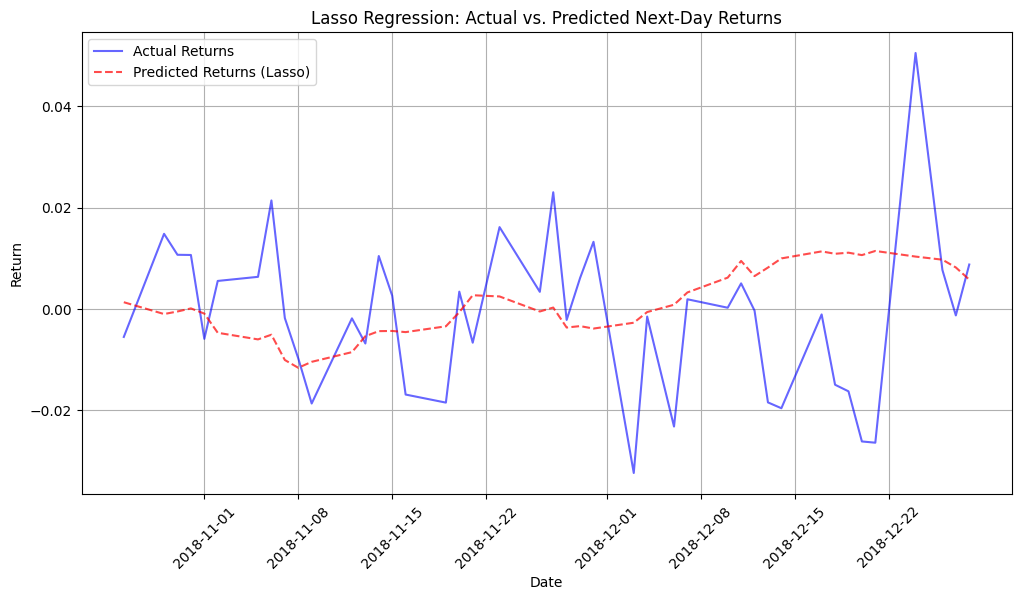

In [56]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the dataset (important for Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Lasso model with lower alpha
lasso_model = Lasso(alpha=0.0001)  # Reduced alpha to retain more features
lasso_model.fit(X_train_scaled, y_train)

# Predict
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate model performance
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

# Print results
print("Lasso Regression Results:")
print(f"Mean Squared Error (MSE): {lasso_mse:.6f}")
print(f"R-squared (R2): {lasso_r2:.6f}")

# Print selected features (non-zero coefficients)
selected_features = [feature for feature, coef in zip(predictors, lasso_model.coef_) if coef != 0]
print(f"Selected Features by Lasso: {selected_features}")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Returns", color="blue", alpha=0.6)
plt.plot(y_test.index, y_pred_lasso, label="Predicted Returns (Lasso)", color="red", linestyle="dashed", alpha=0.7)

# Formatting the plot
plt.title("Lasso Regression: Actual vs. Predicted Next-Day Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

## Ridge Regression (L2 Regularization)


Ridge Regression Results:
Mean Squared Error (MSE): 0.000295
R-squared (R2): -0.244588


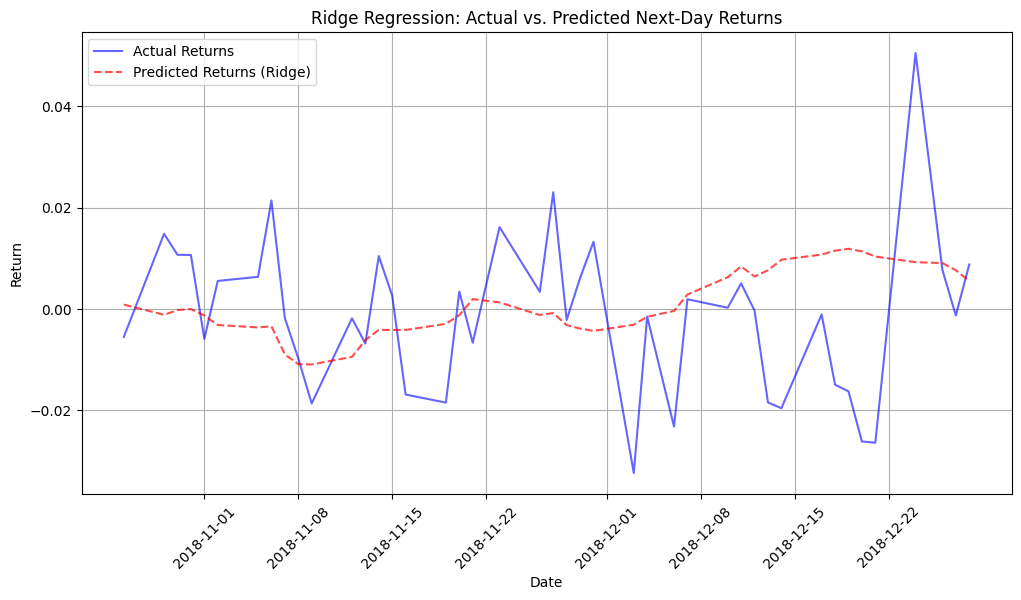

In [60]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Train Ridge model with proper regularization
ridge_model = Ridge(alpha=0.01)  # Adjust alpha as needed
ridge_model.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate model performance
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

# Print results
print("Ridge Regression Results:")
print(f"Mean Squared Error (MSE): {ridge_mse:.6f}")
print(f"R-squared (R2): {ridge_r2:.6f}")

# Plot actual vs predicted returns for Ridge Regression
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Returns", color="blue", alpha=0.6)
plt.plot(y_test.index, y_pred_ridge, label="Predicted Returns (Ridge)", color="red", linestyle="dashed", alpha=0.7)

# Formatting the plot
plt.title("Ridge Regression: Actual vs. Predicted Next-Day Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()


## ElasticNet Regression (Combination of L1 & L2)


ElasticNet Regression Results:
Mean Squared Error (MSE): 0.000250
R-squared (R2): -0.054578
Selected Features by ElasticNet: ['XLRE_lag_5', 'XLRE_lag_40', 'XLV_lag_10']


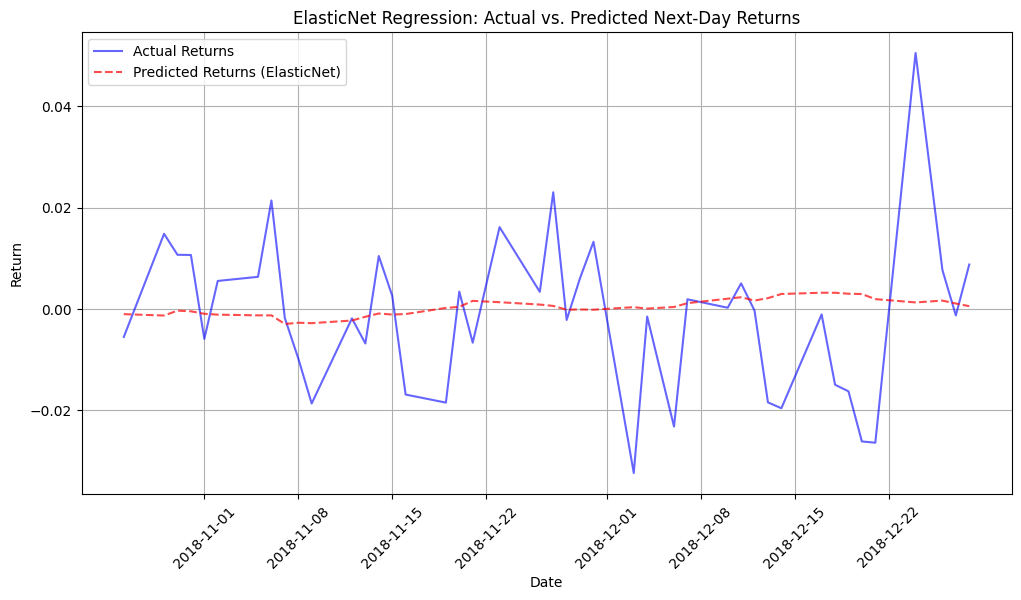

In [61]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train ElasticNet model with proper regularization
elastic_model = ElasticNet(alpha=0.001, l1_ratio=0.5)  # Lower alpha to retain more features
elastic_model.fit(X_train_scaled, y_train)

# Predict
y_pred_elastic = elastic_model.predict(X_test_scaled)

# Evaluate model performance
elastic_mse = mean_squared_error(y_test, y_pred_elastic)
elastic_r2 = r2_score(y_test, y_pred_elastic)

# Print results
print("ElasticNet Regression Results:")
print(f"Mean Squared Error (MSE): {elastic_mse:.6f}")
print(f"R-squared (R2): {elastic_r2:.6f}")

# Print selected features (non-zero coefficients)
selected_features_elastic = [feature for feature, coef in zip(predictors, elastic_model.coef_) if coef != 0]
print(f"Selected Features by ElasticNet: {selected_features_elastic}")

# Plot actual vs predicted returns for ElasticNet Regression
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Returns", color="blue", alpha=0.6)
plt.plot(y_test.index, y_pred_elastic, label="Predicted Returns (ElasticNet)", color="red", linestyle="dashed", alpha=0.7)

# Formatting the plot
plt.title("ElasticNet Regression: Actual vs. Predicted Next-Day Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()


## 5. k-Nearest Neighbors (kNN) Regression

In [52]:
from sklearn.neighbors import KNeighborsRegressor

# Train kNN model (using 5 neighbors)
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Evaluate model performance
knn_mse = mean_squared_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)

# Print results
print("k-Nearest Neighbors (kNN) Regression Results:")
print(f"Mean Squared Error (MSE): {knn_mse:.6f}")
print(f"R-squared (R2): {knn_r2:.6f}")


k-Nearest Neighbors (kNN) Regression Results:
Mean Squared Error (MSE): 0.000288
R-squared (R2): -0.214910


# DS Version

               SPY    XLK   XLRE    XLV  SPY_Return  XLK_Return  XLRE_Return  \
Dt                                                                             
2018-07-24  281.61  73.32  32.32  32.32    0.005032    0.005485    -0.002777   
2018-07-25  284.01  74.24  32.64  32.64    0.008522    0.012548     0.009901   
2018-07-26  283.34  73.10  32.75  32.75   -0.002359   -0.015356     0.003370   
2018-07-27  281.42  71.85  32.45  32.45   -0.006776   -0.017100    -0.009160   
2018-07-30  279.95  70.73  32.42  32.42   -0.005224   -0.015588    -0.000924   
...            ...    ...    ...    ...         ...         ...          ...   
2018-12-24  234.34  57.62  29.81  29.81   -0.026423   -0.026689    -0.036834   
2018-12-26  246.18  61.10  30.76  30.76    0.050525    0.060396     0.031869   
2018-12-27  248.07  61.54  30.83  30.83    0.007677    0.007201     0.002276   
2018-12-28  247.75  61.40  30.94  30.94   -0.001290   -0.002275     0.003568   
2018-12-31  249.92  61.98  31.00  31.00 

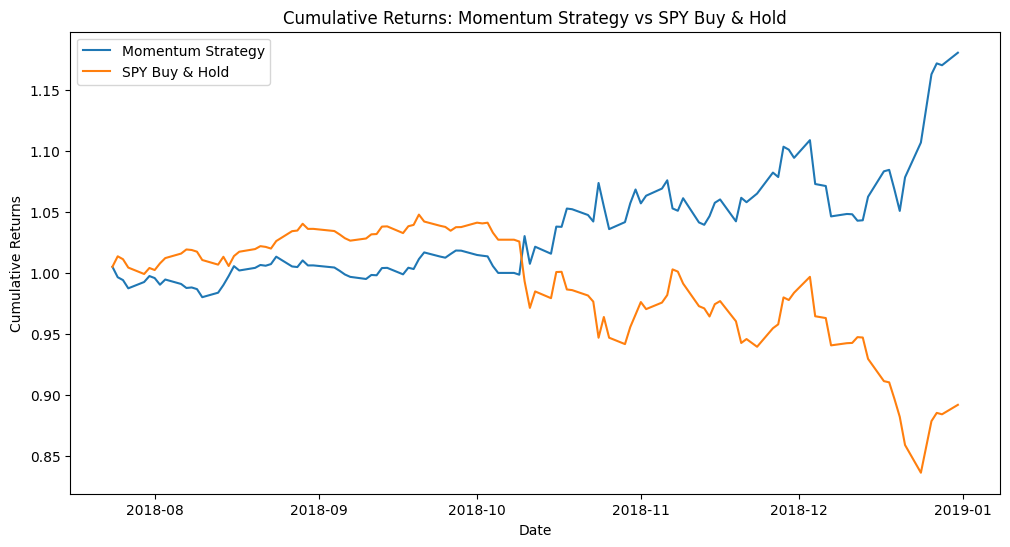

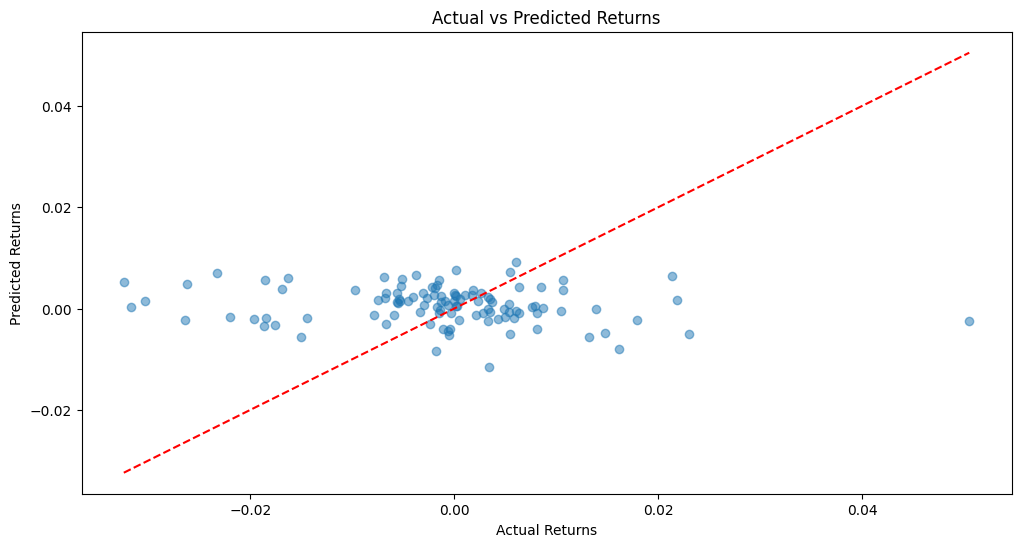

Mean Squared Error (MSE): 0.000168
R-squared (R²): -0.2199
Final Cumulative Return - Momentum Strategy: 1.18
Final Cumulative Return - SPY Buy & Hold: 0.89


In [77]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
spy_data = pd.read_csv('A2csv files/SPY.csv', parse_dates=['Dt'], index_col='Dt')
xlk_data = pd.read_csv('A2csv files/XLK.csv', parse_dates=['Dt'], index_col='Dt')
xlre_data = pd.read_csv('A2csv files/XLRE.csv', parse_dates=['Dt'], index_col='Dt')
xlv_data = pd.read_csv('A2csv files/XLRE.csv', parse_dates=['Dt'], index_col='Dt')

# Merge the data on the Date index
data = pd.concat([spy_data['Close'], xlk_data['Close'], xlre_data['Close'], xlv_data['Close']], axis=1)
data.columns = ['SPY', 'XLK', 'XLRE', 'XLV']

# Calculate daily returns
data['SPY_Return'] = data['SPY'].pct_change()
data['XLK_Return'] = data['XLK'].pct_change()
data['XLRE_Return'] = data['XLRE'].pct_change()
data['XLV_Return'] = data['XLV'].pct_change()

# Calculate lagged returns for SPY and other indices
lags = [5, 10, 21, 42]  # 1W, 2W, 1M, 2M in trading days
for lag in lags:
    data[f'SPY_Lag_{lag}'] = data['SPY_Return'].shift(lag)
    data[f'XLK_Lag_{lag}'] = data['XLK_Return'].shift(lag)
    data[f'XLRE_Lag_{lag}'] = data['XLRE_Return'].shift(lag)
    data[f'XLV_Lag_{lag}'] = data['XLV_Return'].shift(lag)

# Drop rows with NaN values
data.dropna(inplace=True)

# Define the predictor variables (X) and target variable (y)
X_columns = [f'SPY_Lag_{lag}' for lag in lags] + [f'XLK_Lag_{lag}' for lag in lags] + \
            [f'XLRE_Lag_{lag}' for lag in lags] + [f'XLV_Lag_{lag}' for lag in lags]
X = data[X_columns]
y = data['SPY_Return'].shift(-1)  # Next day's return

# Drop rows with NaN values in y
data.dropna(subset=['SPY_Return'], inplace=True)

# Initialize the strategy returns
data['Strategy_Return'] = np.nan

# Rolling window OLS using sklearn
window_size = 100  # 100 trading days
recalibration_freq = 21  # Recalibrate every 21 trading days (~1 month)

# Store predictions and actual values for evaluation
all_predictions = []
all_actuals = []

for i in range(window_size, len(data), recalibration_freq):
    X_train = X.iloc[i-window_size:i]
    y_train = y.iloc[i-window_size:i]
    
    # Fit OLS model using LinearRegression from sklearn
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict next day's return
    X_test = X.iloc[i:i+recalibration_freq]
    predictions = model.predict(X_test)
    
    # Store predictions and actual values
    all_predictions.extend(predictions)
    all_actuals.extend(y.iloc[i:i+recalibration_freq])
    
    # Assign predictions to the strategy returns
    data.loc[X_test.index, 'Strategy_Return'] = predictions

# Drop rows with NaN values in Strategy_Return
data.dropna(subset=['Strategy_Return'], inplace=True)

# Implement the trading strategy
data['Position'] = np.where(data['Strategy_Return'] > 0, 1, -1)  # Long if predicted return > 0, else short
data['Strategy_PnL'] = data['Position'] * data['SPY_Return']

# Calculate cumulative returns
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_PnL']).cumprod()
data['Cumulative_SPY_Return'] = (1 + data['SPY_Return']).cumprod()

print(data)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy_Return'], label='Momentum Strategy')
plt.plot(data['Cumulative_SPY_Return'], label='SPY Buy & Hold')
plt.title('Cumulative Returns: Momentum Strategy vs SPY Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Convert all_actuals and all_predictions to numpy arrays
all_actuals = np.array(all_actuals)
all_predictions = np.array(all_predictions)

# Remove NaN values from both arrays
valid_indices = ~np.isnan(all_actuals) & ~np.isnan(all_predictions)
all_actuals_clean = all_actuals[valid_indices]
all_predictions_clean = all_predictions[valid_indices]

# Plot actual vs predicted returns
plt.figure(figsize=(12, 6))
plt.scatter(all_actuals_clean, all_predictions_clean, alpha=0.5)
plt.plot([min(all_actuals_clean), max(all_actuals_clean)], [min(all_actuals_clean), max(all_actuals_clean)], color='red', linestyle='--')  # 45-degree line
plt.title('Actual vs Predicted Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.show()

# Calculate MSE and R-squared
mse = mean_squared_error(all_actuals_clean, all_predictions_clean)
r2 = r2_score(all_actuals_clean, all_predictions_clean)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R-squared (R²): {r2:.4f}")

# Print final cumulative returns
print(f"Final Cumulative Return - Momentum Strategy: {data['Cumulative_Strategy_Return'].iloc[-1]:.2f}")
print(f"Final Cumulative Return - SPY Buy & Hold: {data['Cumulative_SPY_Return'].iloc[-1]:.2f}")

Model: Lasso
Mean Squared Error (MSE): 0.000141
R-squared (R²): -0.0212
----------------------------------------


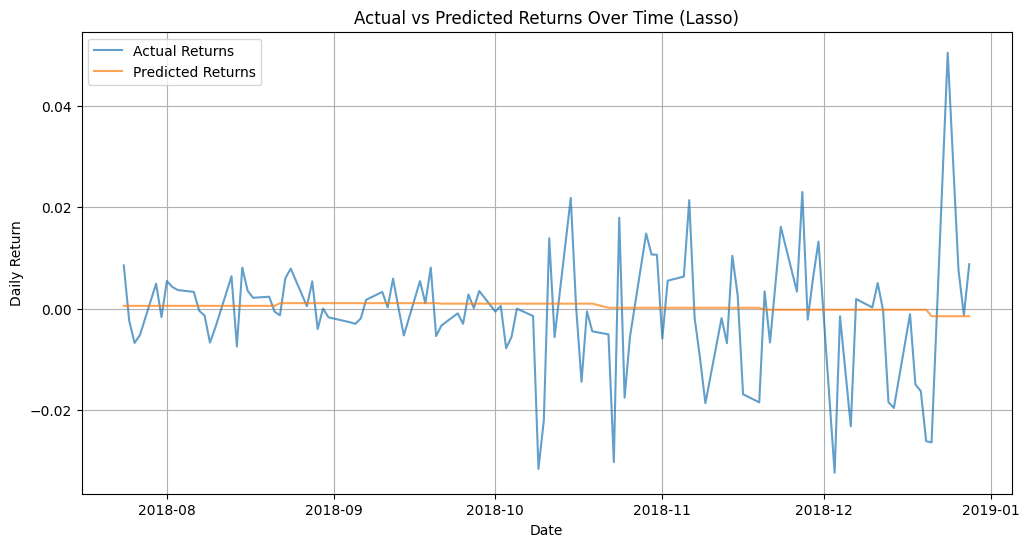

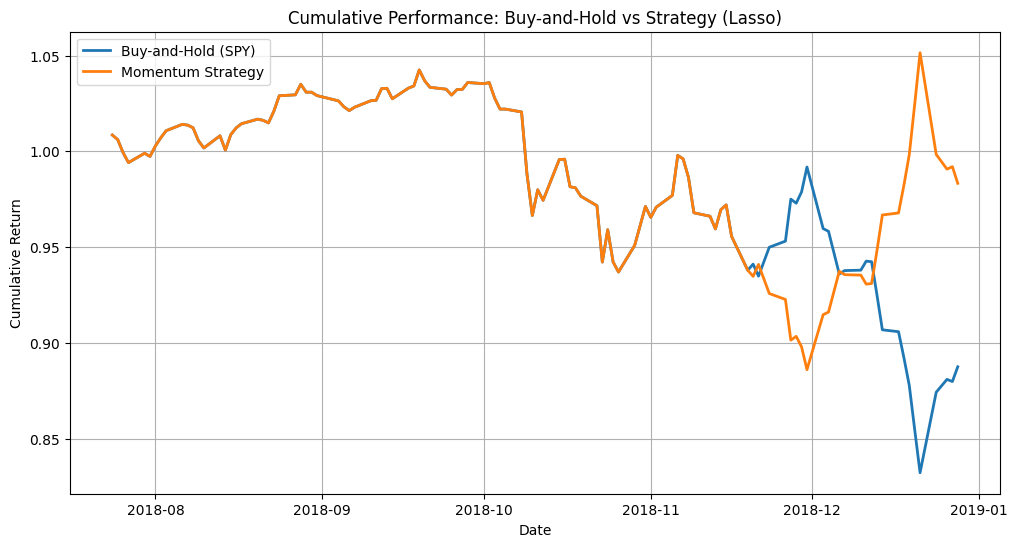

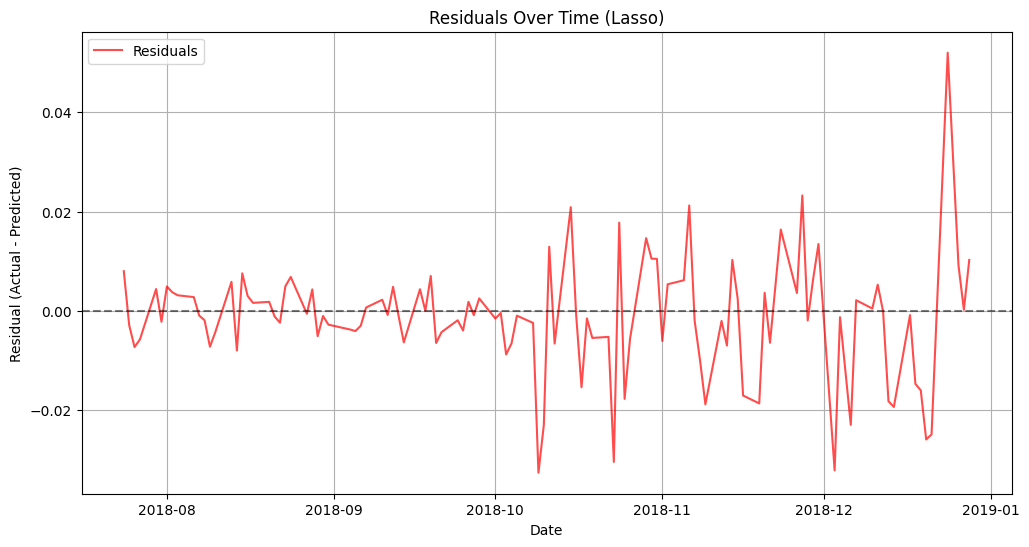

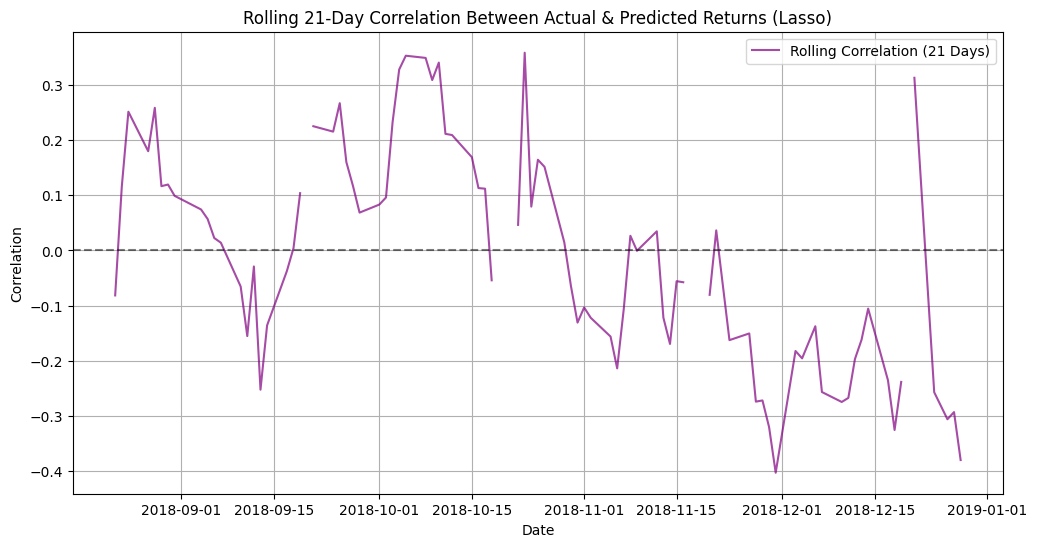

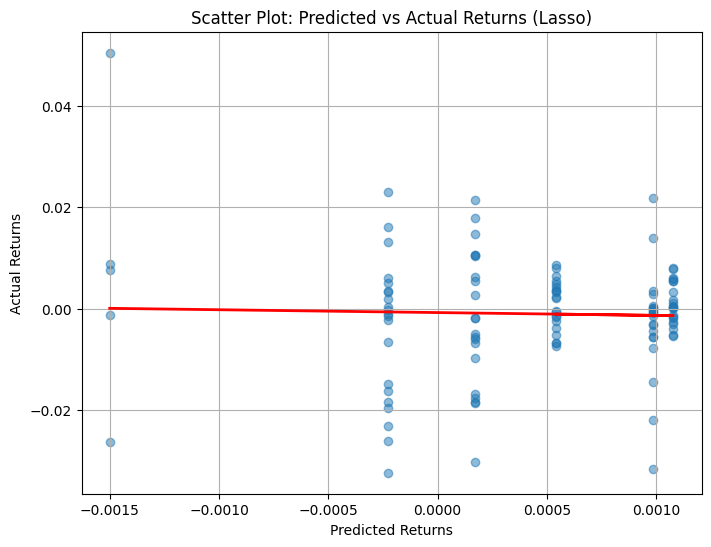

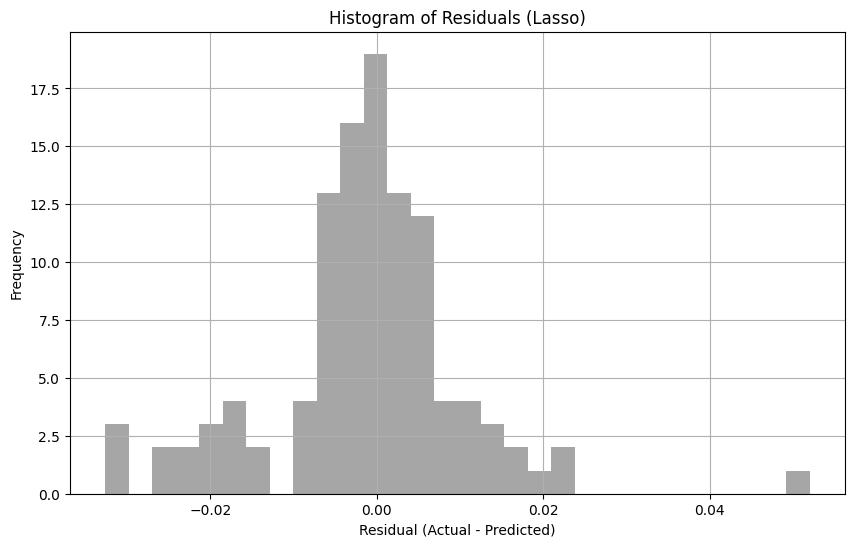

Model: Ridge
Mean Squared Error (MSE): 0.000146
R-squared (R²): -0.0594
----------------------------------------


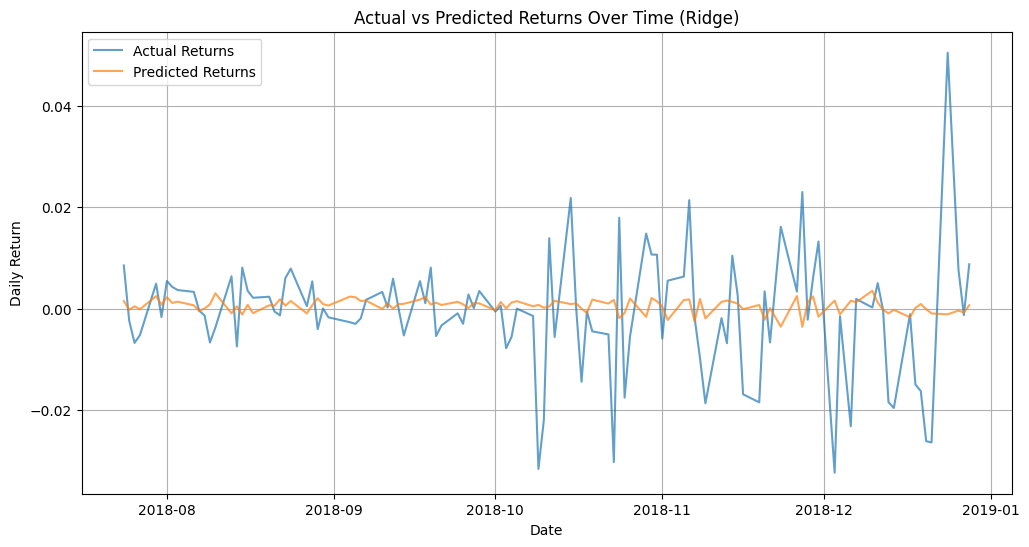

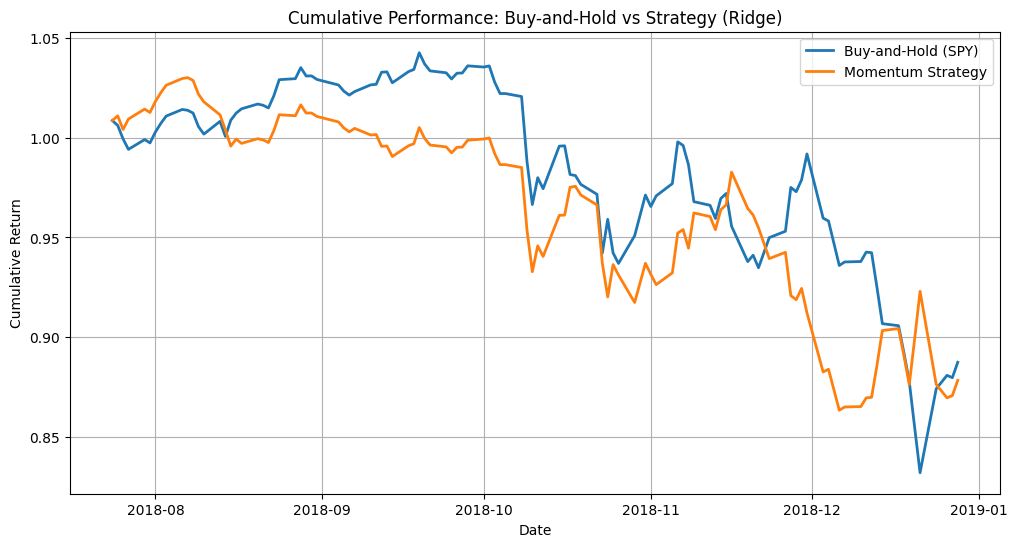

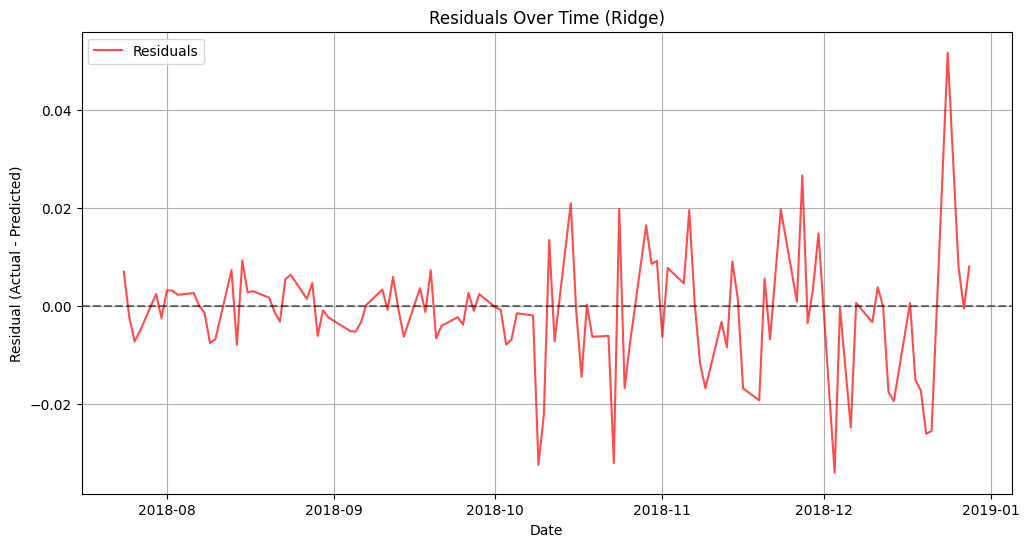

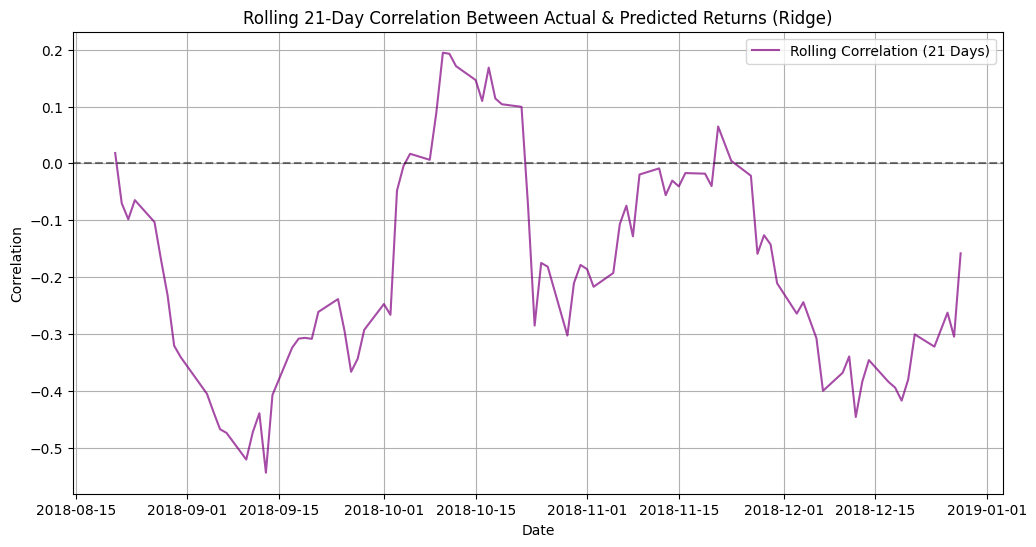

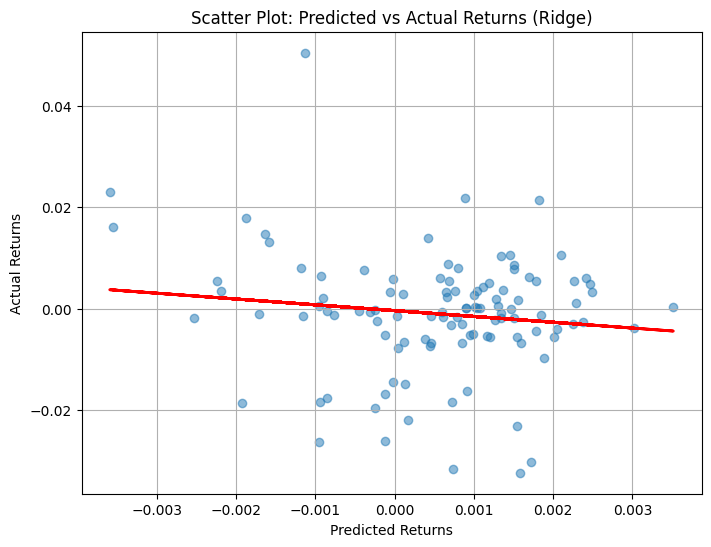

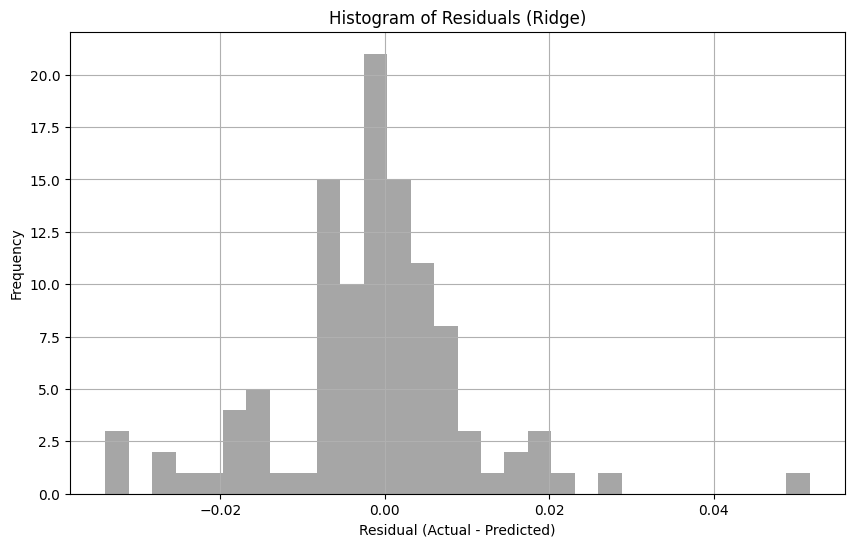

Model: ElasticNet
Mean Squared Error (MSE): 0.000141
R-squared (R²): -0.0212
----------------------------------------


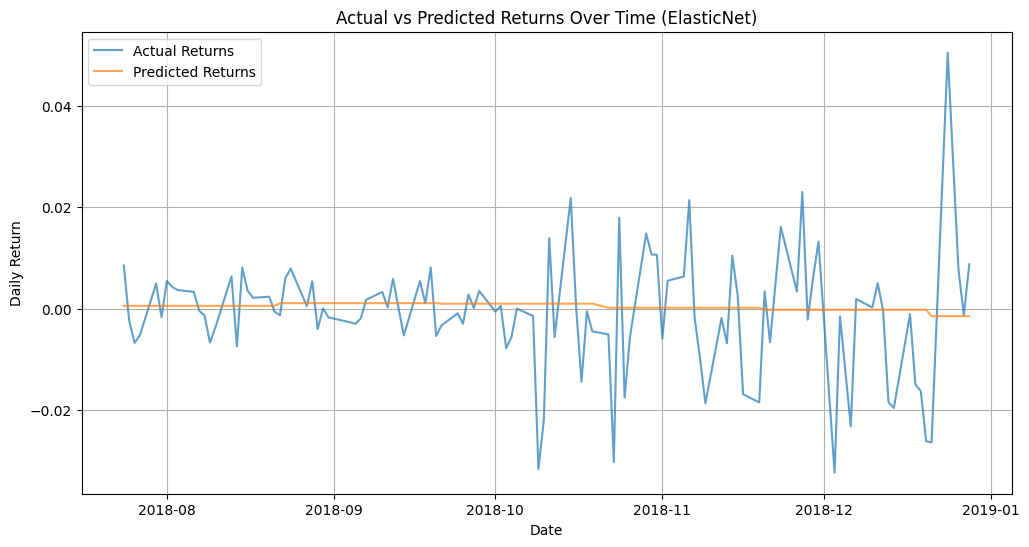

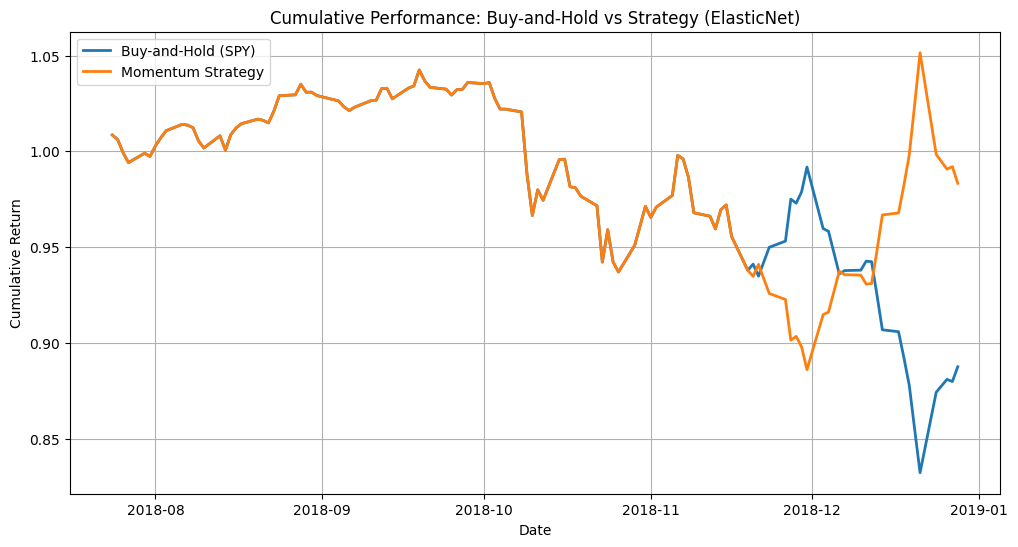

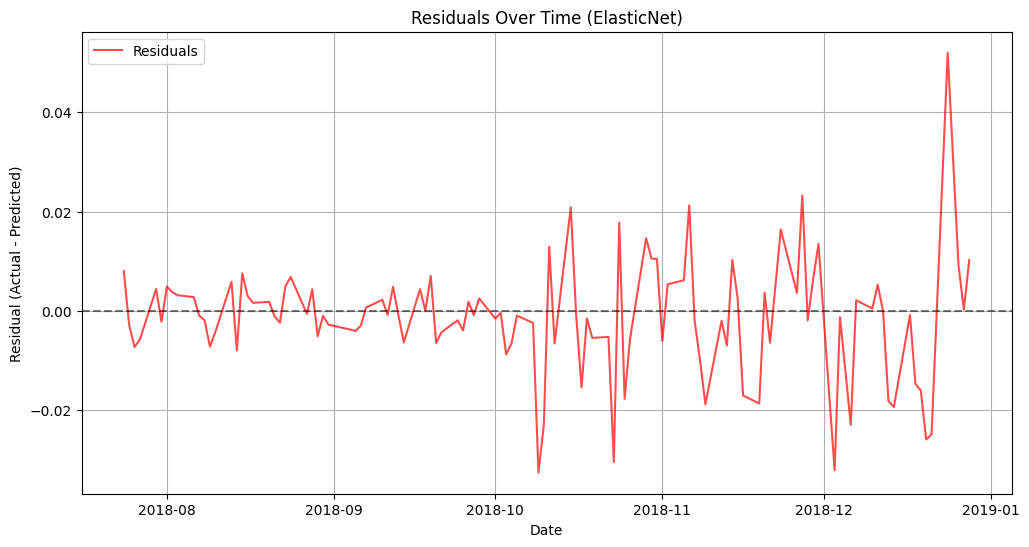

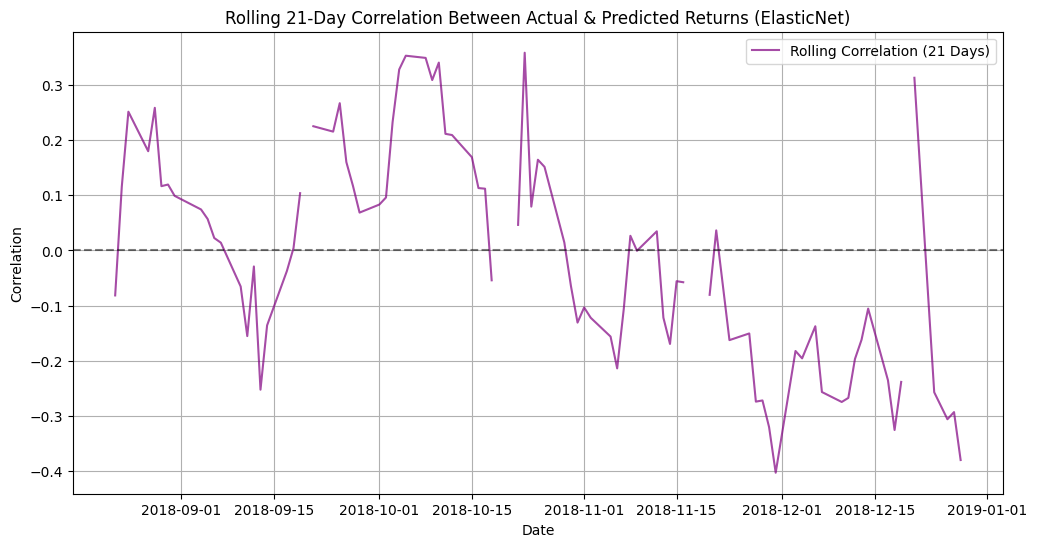

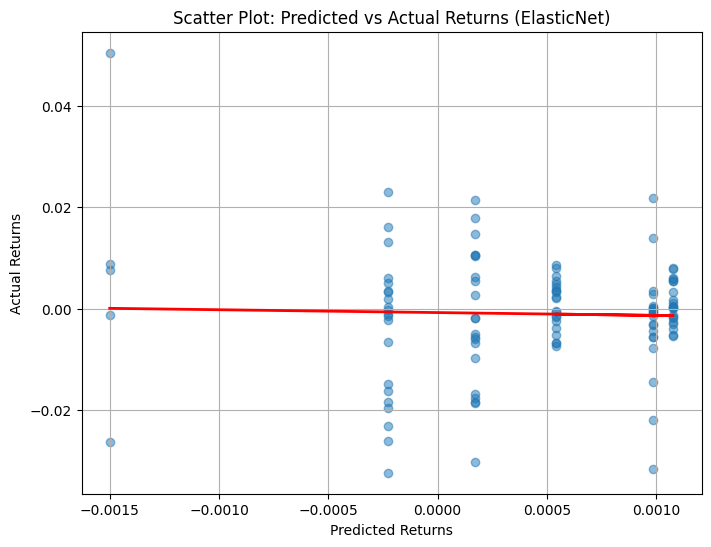

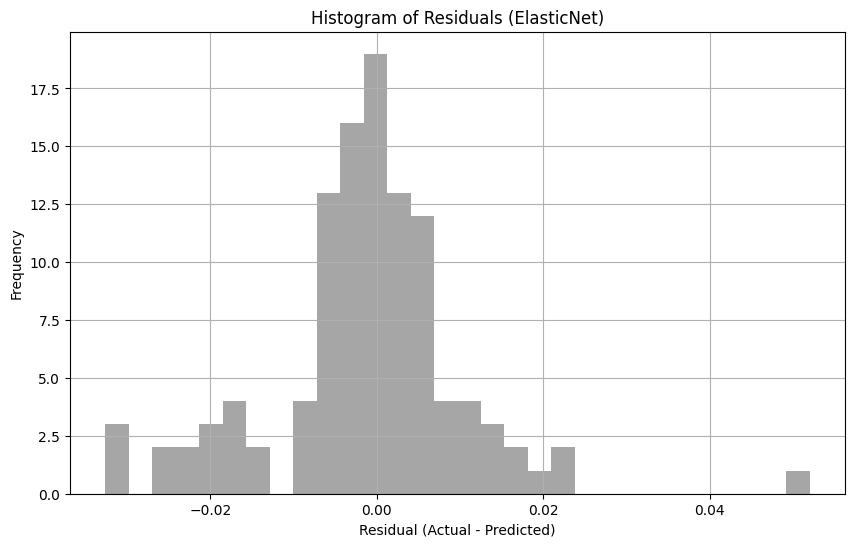

Model: kNN
Mean Squared Error (MSE): 0.000164
R-squared (R²): -0.1939
----------------------------------------


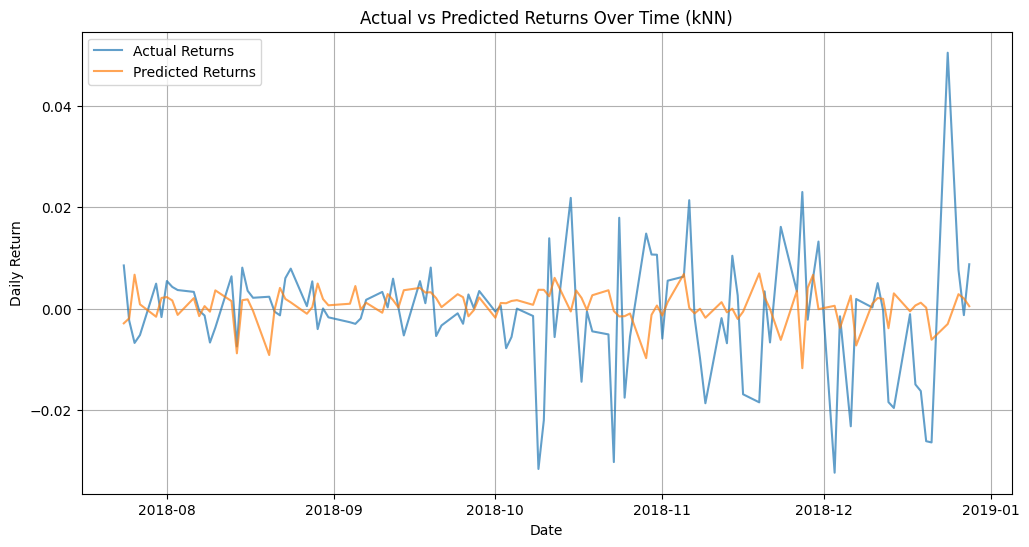

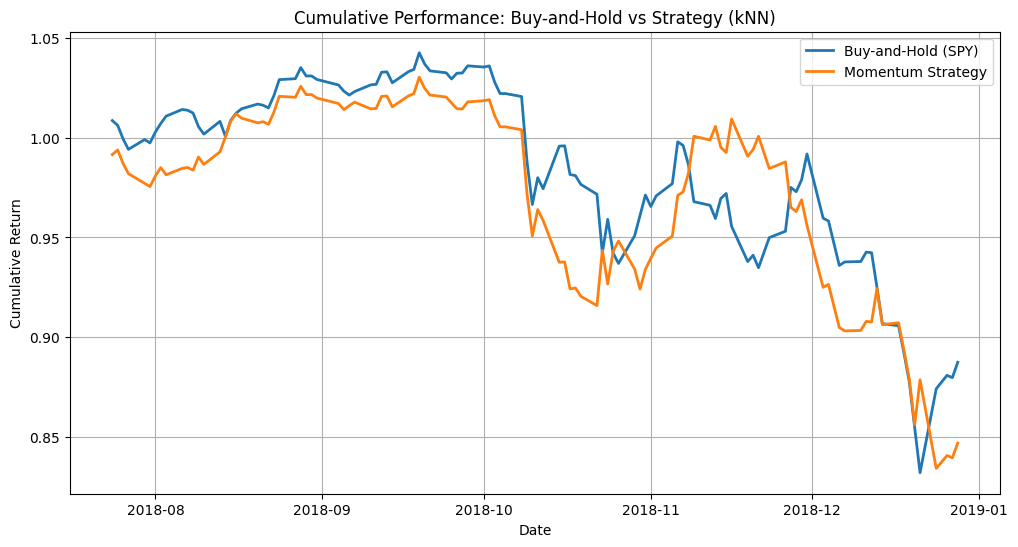

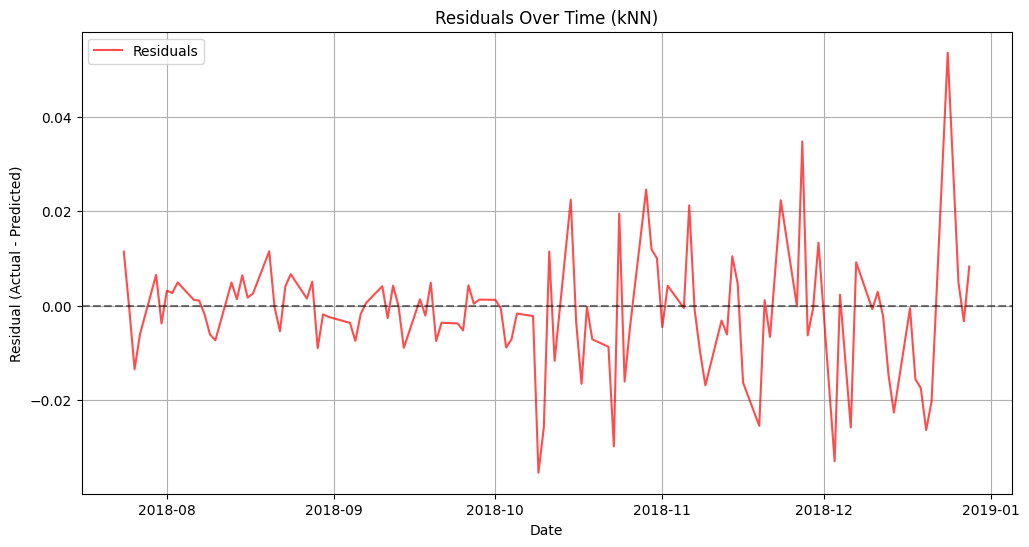

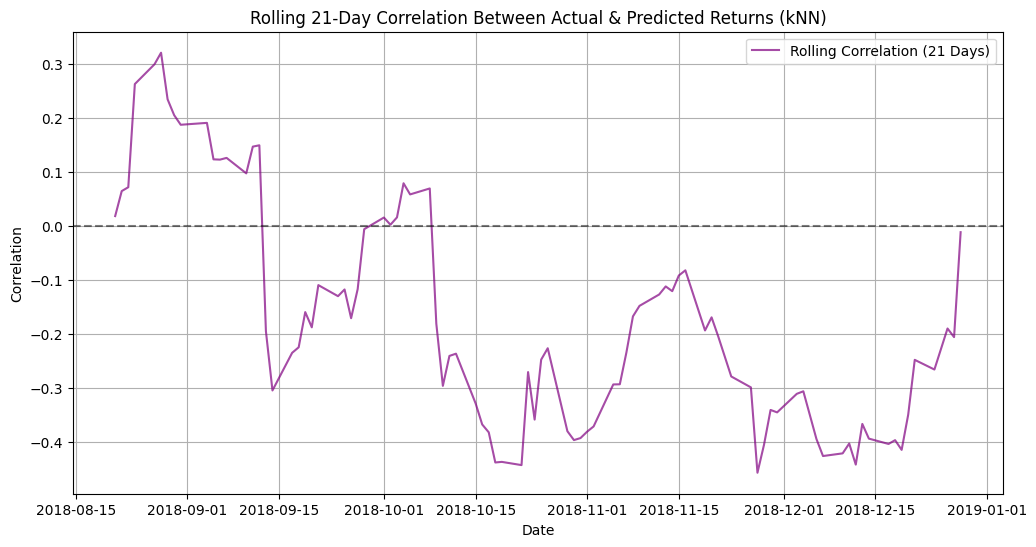

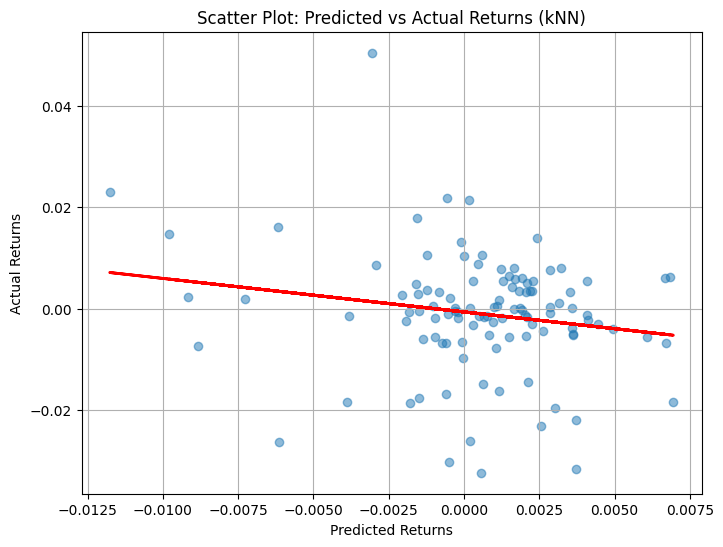

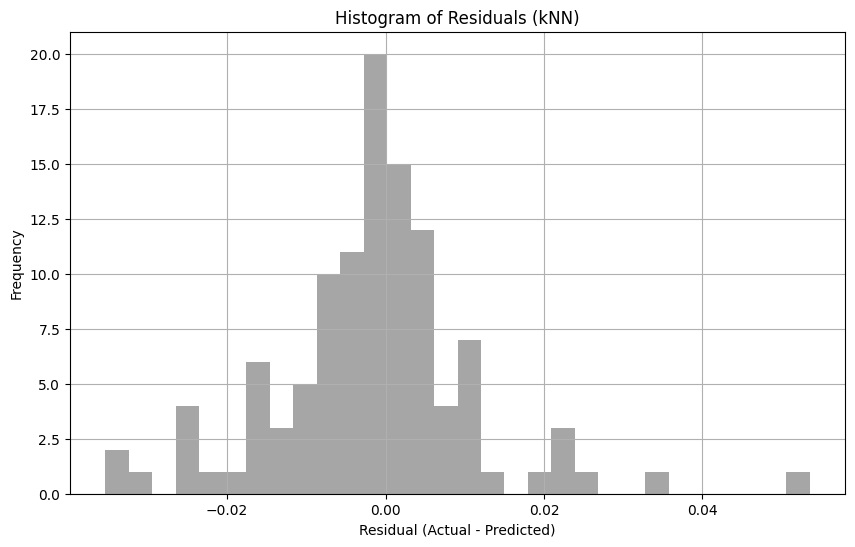

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the regression and other models as well as metrics
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------
# 1. Load and Prepare the Data
# -------------------------------

# Read CSV files and set 'Dt' as the DateTime index
spy_data  = pd.read_csv('A2csv files/SPY.csv', parse_dates=['Dt'], index_col='Dt')
xlk_data  = pd.read_csv('A2csv files/XLK.csv', parse_dates=['Dt'], index_col='Dt')
xlre_data = pd.read_csv('A2csv files/XLRE.csv', parse_dates=['Dt'], index_col='Dt')
xlv_data  = pd.read_csv('A2csv files/XLV.csv', parse_dates=['Dt'], index_col='Dt')  # fixed file name

# Merge the data on the Date index
data = pd.concat([spy_data['Close'], xlk_data['Close'], xlre_data['Close'], xlv_data['Close']], axis=1)
data.columns = ['SPY', 'XLK', 'XLRE', 'XLV']

# Calculate daily returns for each asset
data['SPY_Return']  = data['SPY'].pct_change()
data['XLK_Return']  = data['XLK'].pct_change()
data['XLRE_Return'] = data['XLRE'].pct_change()
data['XLV_Return']  = data['XLV'].pct_change()

# Calculate lagged returns for SPY and the three indices
lags = [5, 10, 21, 42]  # representing ~1W, 2W, 1M, 2M trading days
for lag in lags:
    data[f'SPY_Lag_{lag}']  = data['SPY_Return'].shift(lag)
    data[f'XLK_Lag_{lag}']  = data['XLK_Return'].shift(lag)
    data[f'XLRE_Lag_{lag}'] = data['XLRE_Return'].shift(lag)
    data[f'XLV_Lag_{lag}']  = data['XLV_Return'].shift(lag)

# Drop any rows with NaN values that result from shifting
data.dropna(inplace=True)

# Define the predictor variables (features) and the target variable.
# The target is the next day's SPY return.
X_columns = ([f'SPY_Lag_{lag}' for lag in lags] + 
             [f'XLK_Lag_{lag}' for lag in lags] +
             [f'XLRE_Lag_{lag}' for lag in lags] +
             [f'XLV_Lag_{lag}' for lag in lags])
X = data[X_columns]
y = data['SPY_Return'].shift(-1)  # next day's return

# Remove the last row (or any rows) where y is NaN due to shifting
X = X.iloc[:-1]
y = y.iloc[:-1]
data = data.iloc[:-1]

# -------------------------------
# 2. Set Up Rolling Window & Models
# -------------------------------

# Rolling window parameters: calibration window of 100 days and recalibration every ~1 month (21 days)
window_size = 100  
recalibration_freq = 21  

# Define the models to compare
models = {
    'Lasso':      Lasso(alpha=0.01),
    'Ridge':      Ridge(alpha=0.01),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
    'kNN':        KNeighborsRegressor(n_neighbors=5)
}

# Prepare a dictionary to store predictions, actual values, and dates for each model
results = {model: {'predictions': [], 'actuals': [], 'dates': []} for model in models}

# -------------------------------
# 3. Rolling Window Training and Prediction
# -------------------------------

for i in range(window_size, len(data), recalibration_freq):
    X_train = X.iloc[i-window_size:i]
    y_train = y.iloc[i-window_size:i]
    X_test  = X.iloc[i:i+recalibration_freq]
    y_test  = y.iloc[i:i+recalibration_freq]
    dates_test = X.iloc[i:i+recalibration_freq].index

    for model_name, model in models.items():
        # Fit the model on the training data
        model.fit(X_train, y_train)
        
        # Predict the next day's return for the test period
        predictions = model.predict(X_test)
        
        # Save predictions, actual returns, and dates for evaluation
        results[model_name]['predictions'].extend(predictions)
        results[model_name]['actuals'].extend(y_test)
        results[model_name]['dates'].extend(dates_test)

# -------------------------------
# 4. Evaluation and Visualization
# -------------------------------

for model_name in models:
    # Convert stored lists into numpy arrays
    predictions = np.array(results[model_name]['predictions'])
    actuals     = np.array(results[model_name]['actuals'])
    dates       = np.array(results[model_name]['dates'])
    
    # Ensure there are no NaN values
    valid_indices = ~np.isnan(predictions) & ~np.isnan(actuals)
    predictions = predictions[valid_indices]
    actuals     = actuals[valid_indices]
    dates       = dates[valid_indices]

    # Calculate performance metrics: Mean Squared Error and R-squared
    mse = mean_squared_error(actuals, predictions)
    r2  = r2_score(actuals, predictions)

    print(f"Model: {model_name}")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"R-squared (R²): {r2:.4f}")
    print("-" * 40)

    # Create a DataFrame to organize results, using dates as the index.
    results_df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions
    }, index=dates)
    results_df.sort_index(inplace=True)
    
    # ---------------------------------------------
    # Compute Trading Signals and Strategy Returns:
    # ---------------------------------------------
    # Trading rule: if predicted return > 0, go long (+1); otherwise, go short (-1).
    results_df['Signal'] = np.where(results_df['Predicted'] > 0, 1, -1)
    results_df['Strategy_Return'] = results_df['Signal'] * results_df['Actual']
    
    # Calculate cumulative returns for:
    #  (i) a buy-and-hold SPY strategy (using actual returns), and 
    # (ii) the momentum strategy based on our predictions.
    results_df['Cumulative_Actual'] = (1 + results_df['Actual']).cumprod()
    results_df['Cumulative_Strategy'] = (1 + results_df['Strategy_Return']).cumprod()
    
    # -------------------------------
    # Graph 1: Time Series of Actual vs. Predicted Returns
    # -------------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['Actual'], label='Actual Returns', alpha=0.7)
    plt.plot(results_df.index, results_df['Predicted'], label='Predicted Returns', alpha=0.7)
    plt.title(f'Actual vs Predicted Returns Over Time ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------------------------------
    # Graph 2: Cumulative Performance: Buy-and-Hold vs. Strategy
    # -------------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['Cumulative_Actual'], label='Buy-and-Hold (SPY)', linewidth=2)
    plt.plot(results_df.index, results_df['Cumulative_Strategy'], label='Momentum Strategy', linewidth=2)
    plt.title(f'Cumulative Performance: Buy-and-Hold vs Strategy ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # Graph 3: Residuals Over Time (Actual - Predicted)
    # -------------------------------
    results_df['Residuals'] = results_df['Actual'] - results_df['Predicted']
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['Residuals'], label='Residuals', color='red', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Residuals Over Time ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # Graph 4: Rolling 21-Day Correlation between Actual and Predicted Returns
    # -------------------------------
    results_df['Rolling_Correlation'] = results_df['Actual'].rolling(window=21).corr(results_df['Predicted'])
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['Rolling_Correlation'], label='Rolling Correlation (21 Days)', color='purple', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Rolling 21-Day Correlation Between Actual & Predicted Returns ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # -------------------------------
    # Graph 5: Scatter Plot of Predicted vs Actual Returns
    # -------------------------------
    plt.figure(figsize=(8, 6))
    plt.scatter(results_df['Predicted'], results_df['Actual'], alpha=0.5)
    plt.title(f'Scatter Plot: Predicted vs Actual Returns ({model_name})')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Actual Returns')
    plt.grid(True)
    # Optionally, plot a best-fit line
    m, b = np.polyfit(results_df['Predicted'], results_df['Actual'], 1)
    plt.plot(results_df['Predicted'], m * results_df['Predicted'] + b, color='red', linewidth=2)
    plt.show()
    
    # -------------------------------
    # Graph 6: Histogram of Residuals
    # -------------------------------
    plt.figure(figsize=(10, 6))
    plt.hist(results_df['Residuals'], bins=30, alpha=0.7, color='gray')
    plt.title(f'Histogram of Residuals ({model_name})')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


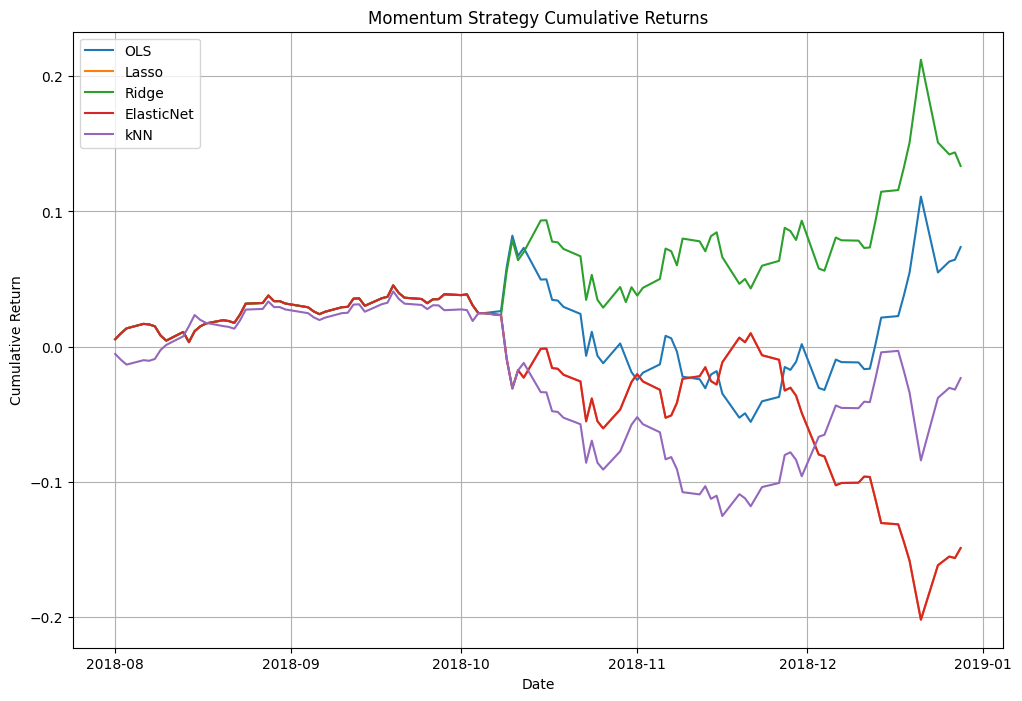

Final Cumulative Returns:
OLS: 7.37%
Lasso: -14.91%
Ridge: 13.37%
ElasticNet: -14.91%
kNN: -2.33%

Regression Performance Metrics:
OLS: MSE = 0.000181, R² = -0.2583
Lasso: MSE = 0.000146, R² = -0.0162
Ridge: MSE = 0.000168, R² = -0.1639
ElasticNet: MSE = 0.000146, R² = -0.0162
kNN: MSE = 0.000165, R² = -0.1481

Additional Strategy Performance Metrics:
OLS: Max Drawdown = -12.74%, Annualized Volatility = 19.08%, Win Rate = 53.85%, Sharpe Ratio = 1.00
Lasso: Max Drawdown = -23.67%, Annualized Volatility = 18.98%, Win Rate = 47.12%, Sharpe Ratio = -1.97
Ridge: Max Drawdown = -6.49%, Annualized Volatility = 19.01%, Win Rate = 52.88%, Sharpe Ratio = 1.70
ElasticNet: Max Drawdown = -23.67%, Annualized Volatility = 18.98%, Win Rate = 47.12%, Sharpe Ratio = -1.97
kNN: Max Drawdown = -15.98%, Annualized Volatility = 19.12%, Win Rate = 46.15%, Sharpe Ratio = -0.20

Directional Accuracy (Prediction Sign vs. Actual Return Sign):
OLS: 53.85%
Lasso: 47.12%
Ridge: 52.88%
ElasticNet: 47.12%
kNN: 46.15

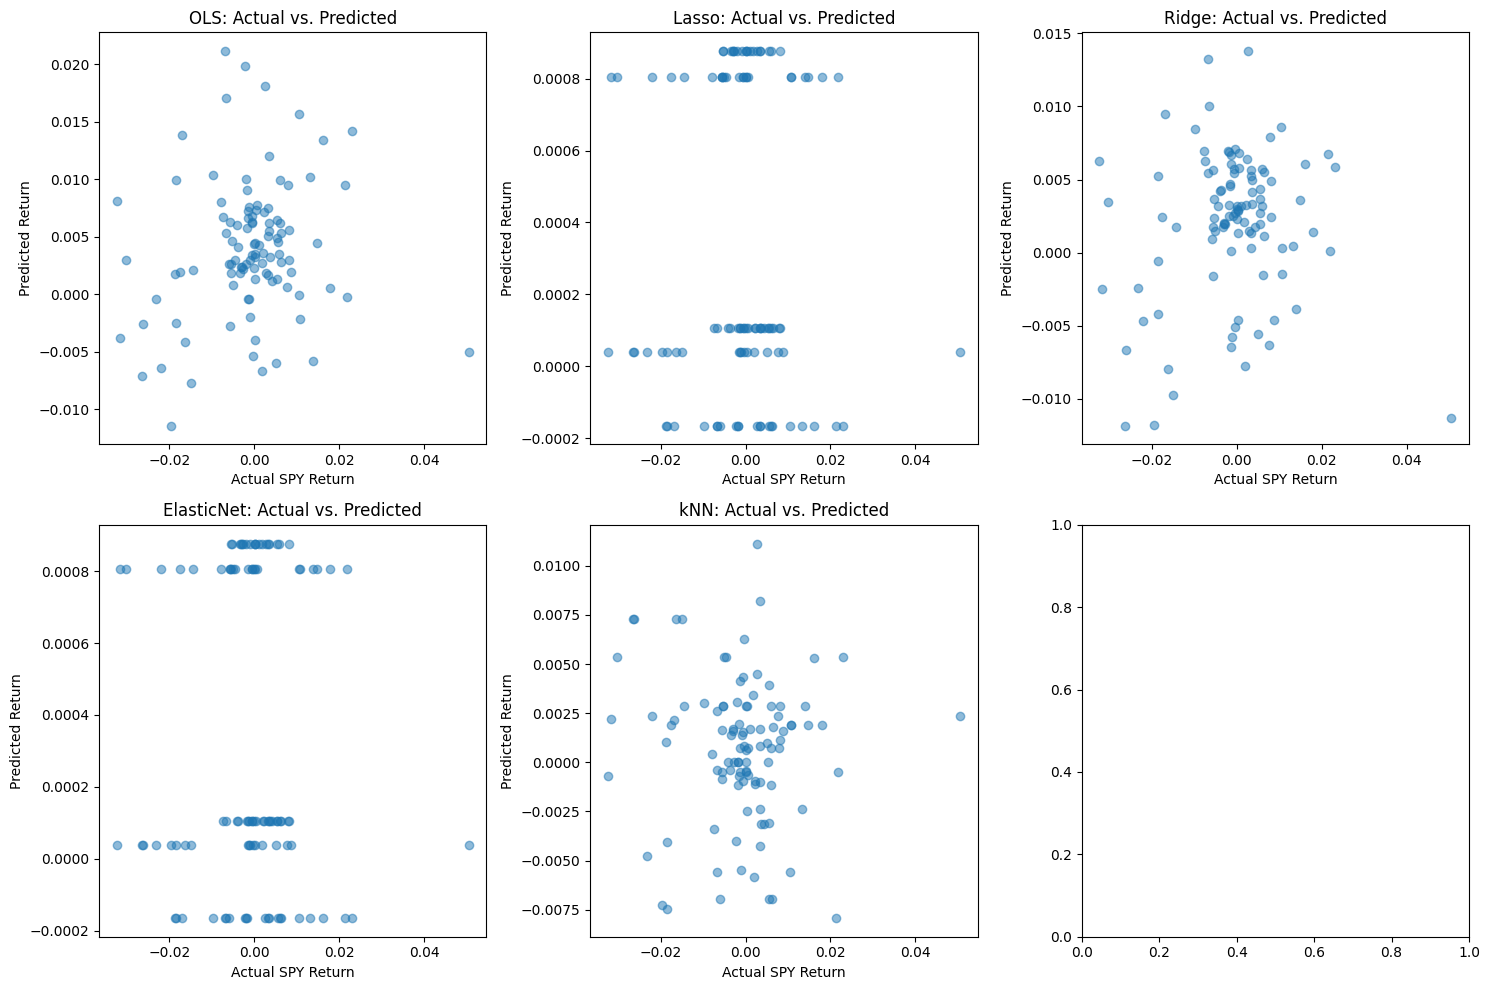

Lasso Predictions Summary:
Min: -0.00016400536524773023
Mean: 0.00033550680464627215
Max: 0.000876280694424637


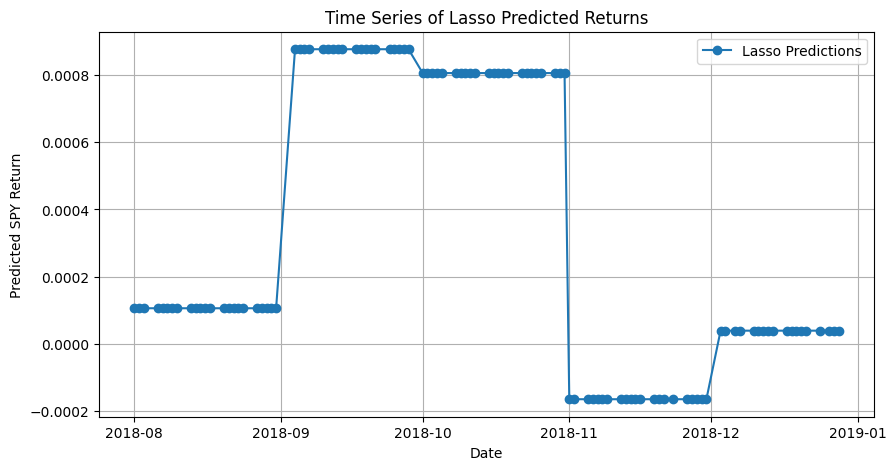

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import regression models and evaluation metrics from scikit-learn.
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load the Data
# ----------------
# Note: Here we load XLF and XLI (instead of XLRE and XLV).
spy = pd.read_csv('A2csv files/SPY.csv', parse_dates=['Dt'], index_col='Dt')
sp = spy.copy()

xlk = pd.read_csv('A2csv files/XLK.csv', parse_dates=['Dt'], index_col='Dt')
xlf = pd.read_csv('A2csv files/XLF.csv', parse_dates=['Dt'], index_col='Dt')
xli = pd.read_csv('A2csv files/XLI.csv', parse_dates=['Dt'], index_col='Dt')

# Merge into one DataFrame (aligned by date)
df = pd.DataFrame(index=spy.index)
df['SPY_Close'] = spy['Close']
df['SP_Close']  = sp['Close']
df['XLK_Close'] = xlk['Close']
df['XLF_Close'] = xlf['Close']
df['XLI_Close'] = xli['Close']

# 2. Compute Lagged Returns (Predictor Variables)
# ------------------------------------------------
# Use four windows: 1W (5 days), 2W (10 days), 1M (21 days), and 2M (42 days)
windows = {'1W': 5, '2W': 10, '1M': 21, '2M': 42}
# Predictor assets: we now use 'XLF_Close' and 'XLI_Close' (renamed as XLF and XLI)
predictor_assets = ['SP_Close', 'XLK_Close', 'XLF_Close', 'XLI_Close']

for asset in predictor_assets:
    short = asset.split('_')[0]
    for label, window in windows.items():
        col_name = f"{short}_{label}"
        df[col_name] = df[asset].pct_change(window).shift(1)

# 3. Compute the Target Variable (Next Day's Return for SPY)
df['SPY_return'] = df['SPY_Close'].pct_change(1).shift(-1)
df.dropna(inplace=True)

# 4. Set Up Rolling Calibration, Prediction, and Trading Simulation
models = {
    'OLS': LinearRegression(),
    'Lasso': Lasso(alpha=0.001, max_iter=10000),
    'Ridge': Ridge(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000),
    'kNN': KNeighborsRegressor(n_neighbors=5)
}

# To store results from each model.
results = {name: {'signal': [], 'spy_ret': [], 'pred': [], 'date': []} for name in models.keys()}

# Recalibrate on the first trading day of each month.
df['YearMonth'] = df.index.to_period('M')
unique_months = df['YearMonth'].unique()

predictor_cols = [f"{short}_{label}" for short in ['SP', 'XLK', 'XLF', 'XLI']
                  for label in windows.keys()]

for ym in unique_months:
    month_data = df[df['YearMonth'] == ym]
    if month_data.empty:
        continue

    recalib_date = month_data.index[0]
    train_data = df[df.index < recalib_date].tail(100)
    if len(train_data) < 100:
        continue

    X_train = train_data[predictor_cols]
    y_train = train_data['SPY_return']

    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model

    for date, row in month_data.iterrows():
        # Use a DataFrame to preserve feature names.
        X_test = row[predictor_cols].to_frame().T
        for name, model in trained_models.items():
            pred = model.predict(X_test)[0]
            results[name]['pred'].append(pred)
            signal = 1 if pred > 0 else -1
            results[name]['signal'].append(signal)
            results[name]['spy_ret'].append(row['SPY_return'])
            results[name]['date'].append(date)

# 5. Additional Performance Metrics Functions
def max_drawdown(cum_returns):
    """Compute the maximum drawdown from a series of cumulative returns."""
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

def annualized_volatility(returns, trading_days=252):
    return np.std(returns) * np.sqrt(trading_days)

def win_rate(returns):
    wins = np.sum(returns > 0)
    total = len(returns)
    return wins / total if total > 0 else np.nan

def sharpe_ratio(returns, trading_days=252):
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    return np.sqrt(trading_days) * mean_ret / std_ret if std_ret != 0 else np.nan

def directional_accuracy(preds, actuals):
    """Compute the percentage of times the sign of the prediction matches the sign of the actual return."""
    preds_sign = np.sign(preds)
    actuals_sign = np.sign(actuals)
    correct = np.sum(preds_sign == actuals_sign)
    total = len(preds)
    return correct / total if total > 0 else np.nan

# 6. Compute Strategy Performance and Plot Cumulative Returns
plt.figure(figsize=(12, 8))
final_perf = {}
performance_metrics = {}
dir_accuracy = {}  # To store directional accuracy for each model

for name in models.keys():
    signals_arr = np.array(results[name]['signal'])
    spy_ret_arr = np.array(results[name]['spy_ret'])
    strat_ret = signals_arr * spy_ret_arr
    # Compute cumulative return (assuming reinvestment)
    cum_ret = np.cumprod(1 + strat_ret) - 1
    final_perf[name] = cum_ret[-1]
    
    # Compute additional metrics:
    mdd = max_drawdown(cum_ret + 1)  # Using portfolio value (cum_ret + 1)
    ann_vol = annualized_volatility(strat_ret)
    wr = win_rate(strat_ret)
    sr = sharpe_ratio(strat_ret)
    performance_metrics[name] = {
        'max_drawdown': mdd,
        'annualized_vol': ann_vol,
        'win_rate': wr,
        'sharpe': sr
    }
    
    plt.plot(results[name]['date'], cum_ret, label=name)
    
    # Also compute directional accuracy using predictions vs. actual returns.
    preds = np.array(results[name]['pred'])
    da = directional_accuracy(preds, spy_ret_arr)
    dir_accuracy[name] = da

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Momentum Strategy Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# 7. Print Summary Performance Metrics
print("Final Cumulative Returns:")
for name, ret in final_perf.items():
    print(f"{name}: {ret:.2%}")

print("\nRegression Performance Metrics:")
for name in models.keys():
    predictions = np.array(results[name]['pred'])
    actuals = np.array(results[name]['spy_ret'])
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    print(f"{name}: MSE = {mse:.6f}, R² = {r2:.4f}")

print("\nAdditional Strategy Performance Metrics:")
for name, metrics in performance_metrics.items():
    print(f"{name}: Max Drawdown = {metrics['max_drawdown']:.2%}, "
          f"Annualized Volatility = {metrics['annualized_vol']:.2%}, "
          f"Win Rate = {metrics['win_rate']:.2%}, "
          f"Sharpe Ratio = {metrics['sharpe']:.2f}")

print("\nDirectional Accuracy (Prediction Sign vs. Actual Return Sign):")
for name, da in dir_accuracy.items():
    print(f"{name}: {da*100:.2f}%")

# 8. Scatter Plot: Actual vs. Predicted Returns for Each Model
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for idx, name in enumerate(models.keys()):
    predictions = np.array(results[name]['pred'])
    actuals = np.array(results[name]['spy_ret'])
    axes[idx].scatter(actuals, predictions, alpha=0.5)
    axes[idx].set_title(f"{name}: Actual vs. Predicted")
    axes[idx].set_xlabel("Actual SPY Return")
    axes[idx].set_ylabel("Predicted Return")
plt.tight_layout()
plt.show()

# Diagnose Lasso Predictions
lasso_preds = np.array(results['Lasso']['pred'])
print("Lasso Predictions Summary:")
print("Min:", lasso_preds.min())
print("Mean:", lasso_preds.mean())
print("Max:", lasso_preds.max())

# Plot Lasso Predictions over time
plt.figure(figsize=(10, 5))
plt.plot(results['Lasso']['date'], lasso_preds, label="Lasso Predictions", marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Predicted SPY Return")
plt.title("Time Series of Lasso Predicted Returns")
plt.legend()
plt.grid(True)
plt.show()



### Cumulative Return:

- Definition: Total compounded return over the sample period.
- Interpretation: Higher cumulative returns indicate a more profitable strategy. For example, a positive cumulative return means the strategy made money over the period.
### Sharpe Ratio:

- Definition: Risk-adjusted return (mean return divided by standard deviation, scaled to annual terms).
- Interpretation: A Sharpe Ratio above 1 is generally considered good; it means that the returns are high relative to the risk. A negative Sharpe Ratio indicates that risk-adjusted performance is poor.
### Maximum Drawdown:

- Definition: The largest peak-to-trough decline in portfolio value.
- Interpretation: Less negative drawdowns indicate lower risk of severe losses. For example, a drawdown of -12% is less severe than one of -24%.
### Annualized Volatility:

- Definition: The standard deviation of daily returns scaled to an annual basis.
- Interpretation: Lower volatility means more stable returns; high volatility indicates larger fluctuations in performance.
### Win Rate:

- Definition: The percentage of trading days in which the strategy generates positive returns.
- Interpretation: A win rate above 50% is generally desirable, suggesting the strategy wins more often than it loses.
### Directional Accuracy:

- Definition: The percentage of times the predicted sign (positive/negative) matches the actual sign of the return.
- Interpretation: Even if the R² is low or negative, a directional accuracy above 50% (e.g., 55% or 60%) can be valuable since the trading signal depends on the direction, not the magnitude.
### Mean Squared Error (MSE):

- Definition: The average squared difference between predicted and actual returns.
- Interpretation: Lower MSE values indicate more accurate predictions. However, given the noise in daily returns, MSE might be low even if the model is not capturing the underlying dynamics well.
### R² (Coefficient of Determination):

- Definition: The proportion of variance in the dependent variable explained by the model.
- Interpretation: In daily return predictions, R² values are often low or even negative due to high noise levels. While a high R² would be ideal, for trading purposes, directional performance and risk-adjusted returns (like the Sharpe Ratio) are often more important than R².

# Application of grid search

Recalibration Date: 2018-08-01 00:00:00, Lasso best params: {'alpha': 0.01, 'fit_intercept': False}
Recalibration Date: 2018-08-01 00:00:00, Ridge best params: {'alpha': 1, 'fit_intercept': False}


/Users/ardadinc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.399e-06, tolerance: 4.246e-07
  model = cd_fast.enet_coordinate_descent(
/Users/ardadinc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.216e-06, tolerance: 4.310e-07
  model = cd_fast.enet_coordinate_descent(
/Users/ardadinc/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Recalibration Date: 2018-08-01 00:00:00, ElasticNet best params: {'alpha': 0.01, 'fit_intercept': False, 'l1_ratio': 0.5}
Recalibration Date: 2018-08-01 00:00:00, kNN best params: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Recalibration Date: 2018-09-04 00:00:00, Lasso best params: {'alpha': 0.01, 'fit_intercept': True}
Recalibration Date: 2018-09-04 00:00:00, Ridge best params: {'alpha': 1, 'fit_intercept': False}
Recalibration Date: 2018-09-04 00:00:00, ElasticNet best params: {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.3}
Recalibration Date: 2018-09-04 00:00:00, kNN best params: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
Recalibration Date: 2018-10-01 00:00:00, Lasso best params: {'alpha': 0.01, 'fit_intercept': False}
Recalibration Date: 2018-10-01 00:00:00, Ridge best params: {'alpha': 1, 'fit_intercept': True}
Recalibration Date: 2018-10-01 00:00:00, ElasticNet best params: {'alpha': 0.01, 'fit_intercept': False, 'l1_ratio': 0.3}
Recalibration Date: 2018-1

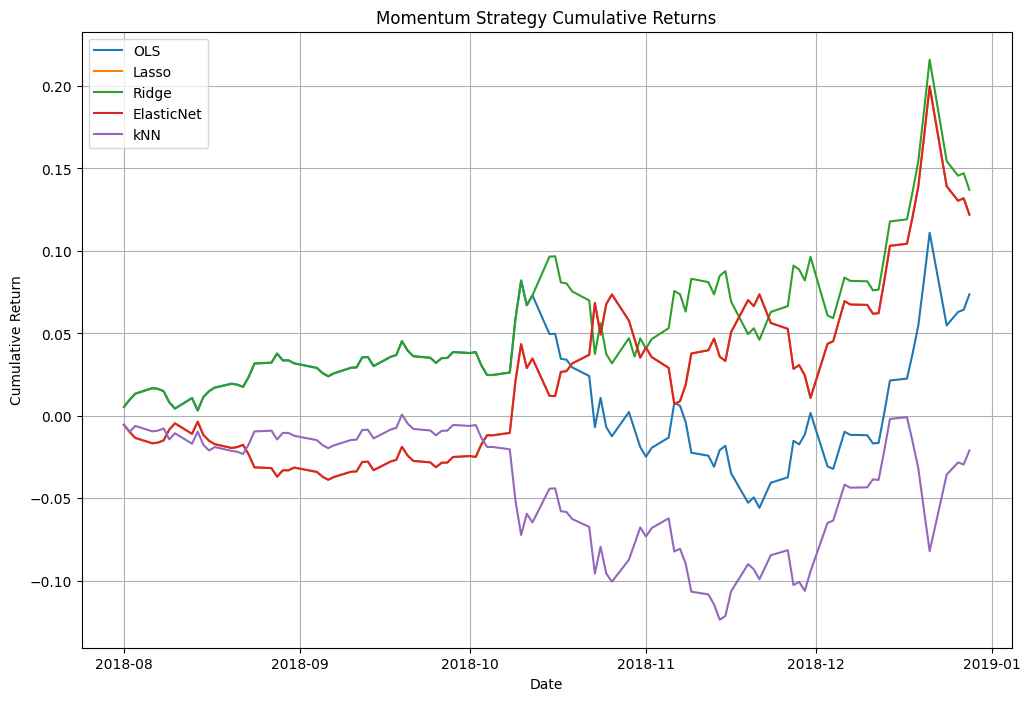

Final Cumulative Returns:
OLS: 7.37%
Lasso: 12.20%
Ridge: 13.70%
ElasticNet: 12.20%
kNN: -2.10%

Regression Performance Metrics:
OLS: MSE = 0.000181, R² = -0.2583
Lasso: MSE = 0.000145, R² = -0.0078
Ridge: MSE = 0.000165, R² = -0.1431
ElasticNet: MSE = 0.000145, R² = -0.0078
kNN: MSE = 0.000156, R² = -0.0857

Additional Strategy Performance Metrics:
OLS: Max Drawdown = -12.74%, Annualized Volatility = 19.08%, Win Rate = 53.85%, Sharpe Ratio = 1.00
Lasso: Max Drawdown = -6.49%, Annualized Volatility = 19.03%, Win Rate = 53.85%, Sharpe Ratio = 1.56
Ridge: Max Drawdown = -6.49%, Annualized Volatility = 19.01%, Win Rate = 53.85%, Sharpe Ratio = 1.73
ElasticNet: Max Drawdown = -6.49%, Annualized Volatility = 19.03%, Win Rate = 53.85%, Sharpe Ratio = 1.56
kNN: Max Drawdown = -12.42%, Annualized Volatility = 19.12%, Win Rate = 48.08%, Sharpe Ratio = -0.17

Directional Accuracy (Prediction Sign vs. Actual Return Sign):
OLS: 53.85%
Lasso: 11.54%
Ridge: 53.85%
ElasticNet: 11.54%
kNN: 48.08%


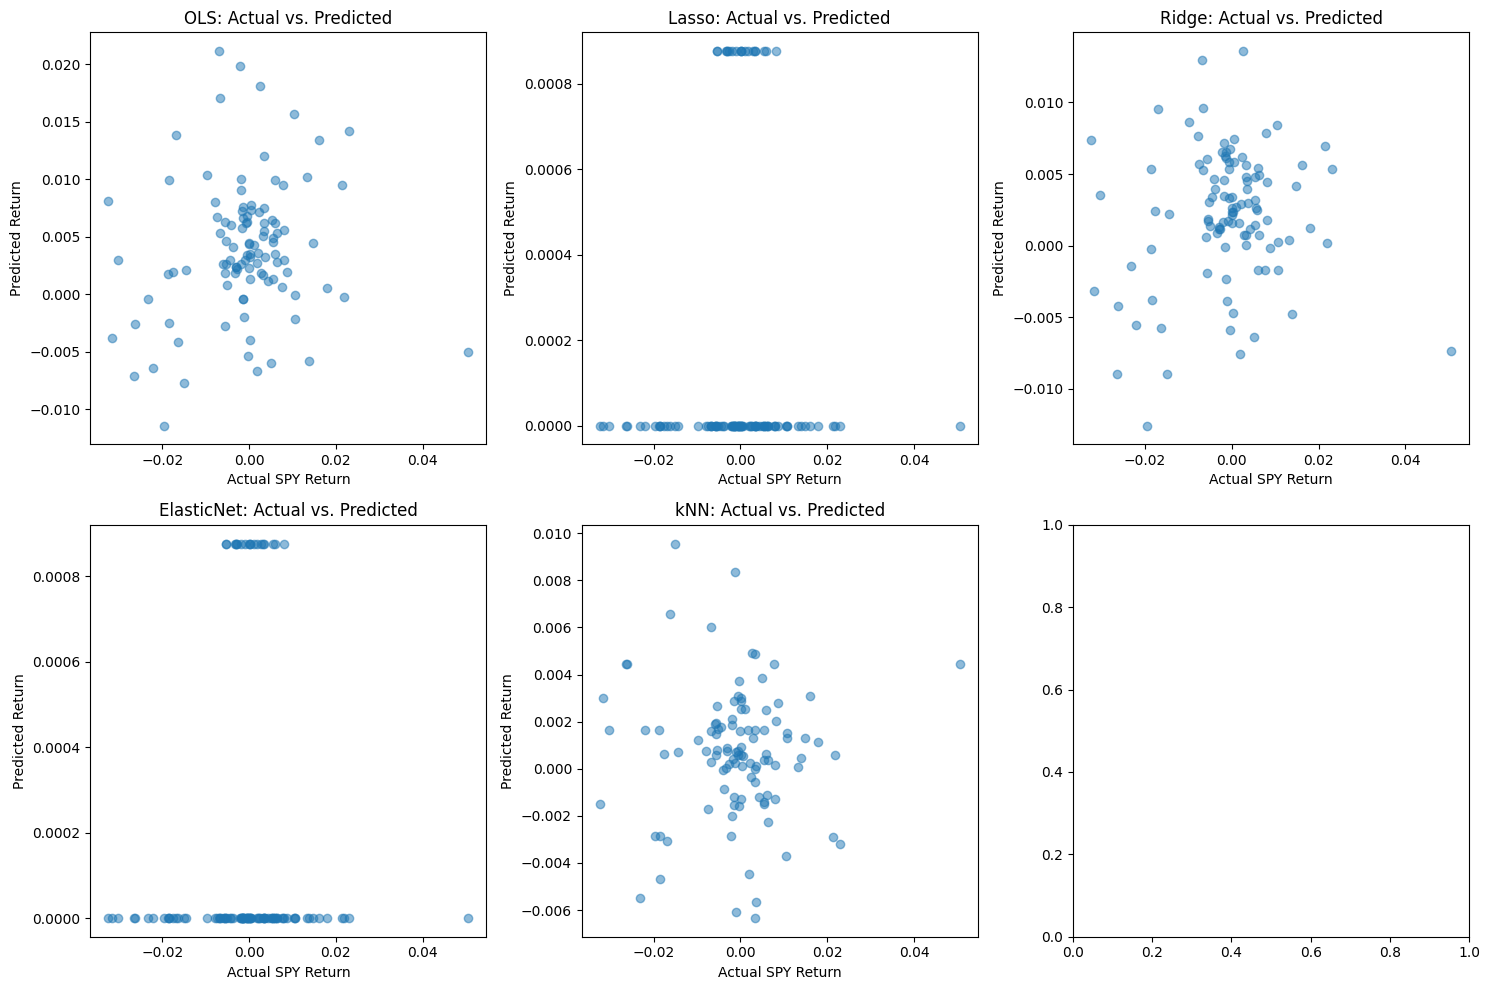


Grid Search Best Parameters by Recalibration Period:

Lasso:
  Date: 2018-08-01 00:00:00, Best Params: {'alpha': 0.01, 'fit_intercept': False}
  Date: 2018-09-04 00:00:00, Best Params: {'alpha': 0.01, 'fit_intercept': True}
  Date: 2018-10-01 00:00:00, Best Params: {'alpha': 0.01, 'fit_intercept': False}
  Date: 2018-11-01 00:00:00, Best Params: {'alpha': 0.001, 'fit_intercept': False}
  Date: 2018-12-03 00:00:00, Best Params: {'alpha': 0.01, 'fit_intercept': False}

Ridge:
  Date: 2018-08-01 00:00:00, Best Params: {'alpha': 1, 'fit_intercept': False}
  Date: 2018-09-04 00:00:00, Best Params: {'alpha': 1, 'fit_intercept': False}
  Date: 2018-10-01 00:00:00, Best Params: {'alpha': 1, 'fit_intercept': True}
  Date: 2018-11-01 00:00:00, Best Params: {'alpha': 1, 'fit_intercept': False}
  Date: 2018-12-03 00:00:00, Best Params: {'alpha': 0.1, 'fit_intercept': False}

ElasticNet:
  Date: 2018-08-01 00:00:00, Best Params: {'alpha': 0.01, 'fit_intercept': False, 'l1_ratio': 0.5}
  Date: 2018

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import regression models, StandardScaler, GridSearchCV, TimeSeriesSplit, and evaluation metrics.
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load the Data
# ----------------
# Note: We load XLF and XLI (instead of XLRE and XLV) as specified.
spy = pd.read_csv('A2csv files/SPY.csv', parse_dates=['Dt'], index_col='Dt')
sp = spy.copy()

xlk = pd.read_csv('A2csv files/XLK.csv', parse_dates=['Dt'], index_col='Dt')
xlf = pd.read_csv('A2csv files/XLF.csv', parse_dates=['Dt'], index_col='Dt')
xli = pd.read_csv('A2csv files/XLI.csv', parse_dates=['Dt'], index_col='Dt')

# Merge into one DataFrame (aligned by date)
df = pd.DataFrame(index=spy.index)
df['SPY_Close'] = spy['Close']
df['SP_Close']  = sp['Close']
df['XLK_Close'] = xlk['Close']
df['XLF_Close'] = xlf['Close']
df['XLI_Close'] = xli['Close']

# 2. Compute Lagged Returns (Predictor Variables)
# ------------------------------------------------
# Use four windows: 1W (5 days), 2W (10 days), 1M (21 days), and 2M (42 days)
windows = {'1W': 5, '2W': 10, '1M': 21, '2M': 42}
# Predictor assets: we now use 'XLF_Close' and 'XLI_Close'
predictor_assets = ['SP_Close', 'XLK_Close', 'XLF_Close', 'XLI_Close']

for asset in predictor_assets:
    short = asset.split('_')[0]
    for label, window in windows.items():
        col_name = f"{short}_{label}"
        df[col_name] = df[asset].pct_change(window).shift(1)

# 3. Compute the Target Variable (Next Day's Return for SPY)
df['SPY_return'] = df['SPY_Close'].pct_change(1).shift(-1)
df.dropna(inplace=True)

# 4. Set Up Rolling Calibration, Prediction, and Trading Simulation
# ------------------------------------------------------------------
# Define base models.
base_models = {
    'OLS': LinearRegression(),
    'Lasso': Lasso(max_iter=10000),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(l1_ratio=0.5, max_iter=10000),
    'kNN': KNeighborsRegressor()
}

# Define an expanded parameter grid for grid search.
param_grids = {
    'Lasso': {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1], 'fit_intercept': [True, False]},
    'Ridge': {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1], 'fit_intercept': [True, False]},
    'ElasticNet': {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1], 
                   'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                   'fit_intercept': [True, False]},
    'kNN': {'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]}
}

# Dictionary to store grid search results.
grid_results = {name: [] for name in param_grids.keys()}

# Prepare a dictionary to store results.
results = {name: {'signal': [], 'spy_ret': [], 'pred': [], 'date': []} for name in base_models.keys()}

# Create a column for YearMonth (for recalibration once per month)
df['YearMonth'] = df.index.to_period('M')
unique_months = df['YearMonth'].unique()

# Define the predictor columns.
predictor_cols = [f"{short}_{label}" for short in ['SP', 'XLK', 'XLF', 'XLI']
                  for label in windows.keys()]

# Use TimeSeriesSplit for cross-validation in grid search.
tscv = TimeSeriesSplit(n_splits=3)

# Loop over each month (recalibration day is the first day of each month).
for ym in unique_months:
    month_data = df[df['YearMonth'] == ym]
    if month_data.empty:
        continue

    recalib_date = month_data.index[0]
    train_data = df[df.index < recalib_date].tail(100)
    if len(train_data) < 100:
        continue

    # Get training predictors and target.
    X_train = train_data[predictor_cols]
    y_train = train_data['SPY_return']
    
    # Standardize predictors.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    trained_models = {}
    for name, model in base_models.items():
        if name in param_grids:
            grid_search = GridSearchCV(model,
                                       param_grids[name],
                                       scoring='neg_mean_squared_error',
                                       cv=tscv)
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_
            trained_models[name] = best_model
            # Store the best parameters along with the recalibration date.
            grid_results[name].append((recalib_date, grid_search.best_params_))
            print(f"Recalibration Date: {recalib_date}, {name} best params: {grid_search.best_params_}")
        else:
            model.fit(X_train_scaled, y_train)
            trained_models[name] = model

    # For each day in the month, transform X_test using the same scaler and predict.
    for date, row in month_data.iterrows():
        X_test = row[predictor_cols].to_frame().T  # Preserve feature names.
        X_test_scaled = scaler.transform(X_test)   # Standardize using the training scaler.
        for name, model in trained_models.items():
            pred = model.predict(X_test_scaled)[0]
            results[name]['pred'].append(pred)
            signal = 1 if pred > 0 else -1
            results[name]['signal'].append(signal)
            results[name]['spy_ret'].append(row['SPY_return'])
            results[name]['date'].append(date)

# 5. Additional Performance Metrics Functions
def max_drawdown(cum_returns):
    """Compute the maximum drawdown from a series of cumulative returns."""
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

def annualized_volatility(returns, trading_days=252):
    return np.std(returns) * np.sqrt(trading_days)

def win_rate(returns):
    wins = np.sum(returns > 0)
    total = len(returns)
    return wins / total if total > 0 else np.nan

def sharpe_ratio(returns, trading_days=252):
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    return np.sqrt(trading_days) * mean_ret / std_ret if std_ret != 0 else np.nan

def directional_accuracy(preds, actuals):
    """Compute the percentage of times the sign of the prediction matches the sign of the actual return."""
    preds_sign = np.sign(preds)
    actuals_sign = np.sign(actuals)
    correct = np.sum(preds_sign == actuals_sign)
    total = len(preds)
    return correct / total if total > 0 else np.nan

# 6. Compute Strategy Performance and Plot Cumulative Returns
plt.figure(figsize=(12, 8))
final_perf = {}
performance_metrics = {}
dir_accuracy = {}

for name in base_models.keys():
    signals_arr = np.array(results[name]['signal'])
    spy_ret_arr = np.array(results[name]['spy_ret'])
    strat_ret = signals_arr * spy_ret_arr
    # Compute cumulative return (assuming reinvestment)
    cum_ret = np.cumprod(1 + strat_ret) - 1
    final_perf[name] = cum_ret[-1]
    
    mdd = max_drawdown(cum_ret + 1)
    ann_vol = annualized_volatility(strat_ret)
    wr = win_rate(strat_ret)
    sr = sharpe_ratio(strat_ret)
    performance_metrics[name] = {
        'max_drawdown': mdd,
        'annualized_vol': ann_vol,
        'win_rate': wr,
        'sharpe': sr
    }
    
    plt.plot(results[name]['date'], cum_ret, label=name)
    
    preds = np.array(results[name]['pred'])
    da = directional_accuracy(preds, spy_ret_arr)
    dir_accuracy[name] = da

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Momentum Strategy Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# 7. Print Summary Performance Metrics
print("Final Cumulative Returns:")
for name, ret in final_perf.items():
    print(f"{name}: {ret:.2%}")

print("\nRegression Performance Metrics:")
for name in base_models.keys():
    predictions = np.array(results[name]['pred'])
    actuals = np.array(results[name]['spy_ret'])
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    print(f"{name}: MSE = {mse:.6f}, R² = {r2:.4f}")

print("\nAdditional Strategy Performance Metrics:")
for name, metrics in performance_metrics.items():
    print(f"{name}: Max Drawdown = {metrics['max_drawdown']:.2%}, "
          f"Annualized Volatility = {metrics['annualized_vol']:.2%}, "
          f"Win Rate = {metrics['win_rate']:.2%}, "
          f"Sharpe Ratio = {metrics['sharpe']:.2f}")

print("\nDirectional Accuracy (Prediction Sign vs. Actual Return Sign):")
for name, da in dir_accuracy.items():
    print(f"{name}: {da*100:.2f}%")

# 8. Scatter Plot: Actual vs. Predicted Returns for Each Model
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for idx, name in enumerate(base_models.keys()):
    predictions = np.array(results[name]['pred'])
    actuals = np.array(results[name]['spy_ret'])
    axes[idx].scatter(actuals, predictions, alpha=0.5)
    axes[idx].set_title(f"{name}: Actual vs. Predicted")
    axes[idx].set_xlabel("Actual SPY Return")
    axes[idx].set_ylabel("Predicted Return")
plt.tight_layout()
plt.show()

# 9. Print Grid Search Summary for Tuned Models
print("\nGrid Search Best Parameters by Recalibration Period:")
for model_name, params_list in grid_results.items():
    print(f"\n{model_name}:")
    for recalib_date, best_params in params_list:
        print(f"  Date: {recalib_date}, Best Params: {best_params}")
